# Vie et mort d'une population, processus de Yule

AZZOUZI Hamza - MORIN Matéo

### Importation des modules

In [ ]:
# Pour les calculs de probabilité
import numpy as np
import scipy.stats as sps
import numpy.random as npr
from queue import PriorityQueue

# Pour suivre l'avancée des calculs
from tqdm import tqdm
from time import time

# Pour l'affichage des données
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Pour les régressions linéaires
from sklearn.linear_model import LinearRegression

### Affichage des intervalles de confiance

In [ ]:
def plot_confidence_interval(x, values, z=1.96, color='#006769', horizontal_line_width=1):
    "Retourne l'intervalle de confiance asymptotique (à 95% par défaut, modifiable en modifiant le quantile z)"
    mean = np.mean(values)
    std = np.std(values)
    confidence_interval = z * std / np.sqrt(len(values))

    left = x - horizontal_line_width / 2
    top = mean + confidence_interval
    right = x + horizontal_line_width / 2
    bottom = max(mean - confidence_interval, 0)
    plt.plot([x, x], [bottom, top], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='red')

    return mean, confidence_interval

Soit $\lambda > 0$ un paramètre.

Partant d’un individu, on s’intéresse à l’évolution d’une population où chaque individu vit un temps aléatoire distribué suivant une loi exponentielle de paramètre $\lambda$ (indépendamment des autres individus), et meurt en donnant naissance à deux individus. On dit que les individus se reproduisent à un taux $\lambda$ (on rappelle qu’une loi exponentielle de paramètre $\lambda$ a pour densité $\lambda e^{-\lambda x}$ sur R+).

On note $Y_t$ le nombre d’individus présents à l’instant t (ainsi, $Y_0 = 1$ et $Y$ augmente de 1 à chaque fois qu’un individu meurt). Le processus $(Y_t)_{t \geq 0}$ est appelé processus de Yule de paramètre $\lambda$

Pour un entier $C \geq 1$, on notera $Y_t(C)$ le nombre d’individus présents à l’instant t lorsqu’on part de $C$ individus à $t = 0$ (ainsi $Y_t = Y_t(1)$).


## Partie 1

### Approche (A)

Intéressons-nous pour l'instant à la 1D avec $C = 1$.

La propriété $(A)$ nous invite à repenser la loi $Y_t$ avec $t>0$ comme :

$$ X_t = inf \{k \geq 0 | E_1 + E_2 + ... + E_k \geq t \} $$

avec $\forall i \geq 1$, $E_i \sim \varepsilon (i \times \lambda) $

Initialement, un individu existe, et la date de sa mort $t_1$ suit une loi exponentielle de paramètre $\lambda$. Puis, à sa mort, $X_t$ augmente car deux individus naissent, et leur mort suit chacune une loi exponentielle de paramêtre $\lambda$ sachant $t \geq t_1$ : par absence de mémoire, on pourrait alors se ramener à une loi exponentielle de paramètre $\lambda$ avec une nouvelle échelle de temps $t' = t - t_1$. La prochaine mort à $t' = t_2$ a lieue à la valeur minimum des deux tirages suivant la même loi (soit une loi exponentielle de paramètre $ 2 \times \lambda$)  et il y a alors trois individus avec un temps de survie $t' > t_2$ : par l'absence de mémoire on peut réitérer l'opération indéfiniement, et on retombe bien sur cette écriture de $X_t$.

Cette approche ne nous permet pas d'avoir la généalogie mais aide au moins à obtenir une réalisation de $Y_t$, simulons-là :

In [ ]:
def Yule_A(scale:float,t:float):
    """Retourne le résultat final du processus (A)"""
    E = npr.exponential(scale)
    Y = 1
    while t > E :
        Y += 1
        E += npr.exponential(scale/Y)
    return Y


In [ ]:
def fct_Yule_A(scale:float, t : np.ndarray) :
    """Retourne Y_t pour chaque temps indiqué dans le tableau t en suivant le même processus (A)"""
    E = npr.exponential(scale, size = 10000000) #taille arbitrairement élevée
    i=np.arange(10000000) +1
    E=E/i
    E = np.cumsum(E)
    n = len(t)
    Y = np.zeros(n)
    for i in range (n) :    #Pour chaque temps différents
        j= 0
        temps = E[0]
        value = 1
        while t[i] > temps :
            value += 1
            j+=1
            temps = E[j]
        Y[i] = value
    return Y

#### Vérifications des fonctions
D'après $(B)$, $Y_t \sim G (e^{-\lambda t})$, on peut donc vérifier :

In [ ]:
def verif_A_geo(l,t,N=int(1e4)):
    scale = 1/l
    Y = [Yule_A(scale,t) for _ in range(N)]

    #Calcul de la distribution
    distrib = np.bincount(Y)


    #Affichage
    distrib = distrib[1:]

    x = np.arange(min(Y), max(Y) + 1)
    plt.bar(x, distrib/N, label="Loi empirique")

    plt.stem(x,sps.geom.pmf(x,np.exp(-l*t)),linefmt="r", markerfmt="ro", basefmt="None", label='Loi géométrique')
    plt.xlabel('$Y_t$')
    plt.ylabel('Fréquence / Probabilité de réalisation')
    plt.title(f"Evaluation de la méthode pour t = {t}, lambda = {l}")
    plt.legend()

    plt.show()

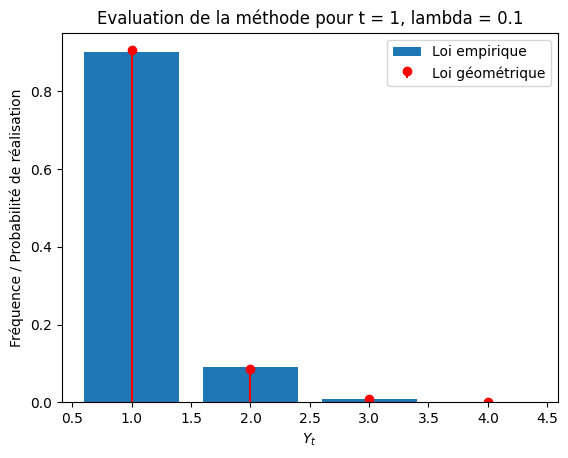

In [ ]:
verif_A_geo(l=0.1,t=1)

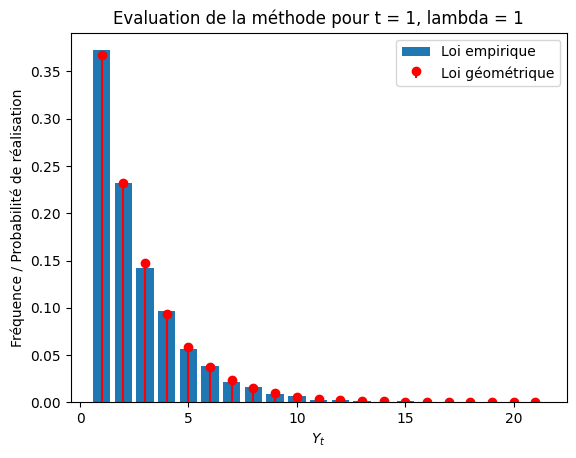

In [ ]:
verif_A_geo(l=1,t=1)

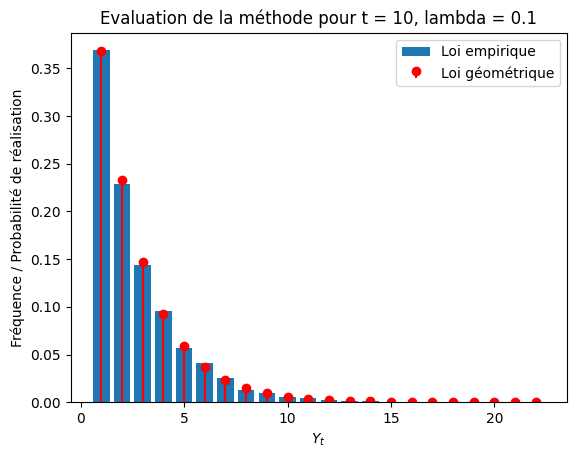

In [ ]:
verif_A_geo(l=0.1,t=10)

La méthode est validée et correcte.

### Représentation graphique

On peut représenter le nombre d'individus au cours du temps facilement grâce à la méthode explorée précédemment :

In [ ]:
def Yule_A_step(l:float,t:float):
    scale = 1/l
    E = npr.exponential(scale)
    Y = 1
    t_death = [0,E]
    while t > E :
        Y += 1
        E += npr.exponential(scale/Y)
        t_death.append(E)
    plt.step(t_death, np.arange(1,Y+2),where='post')
    plt.xlabel("t")
    plt.ylabel("$Y_t$")
    plt.xlim(0,t)
    plt.title(f"Simulation d'un processus de Yule avec lambda = {l}")
    plt.show()

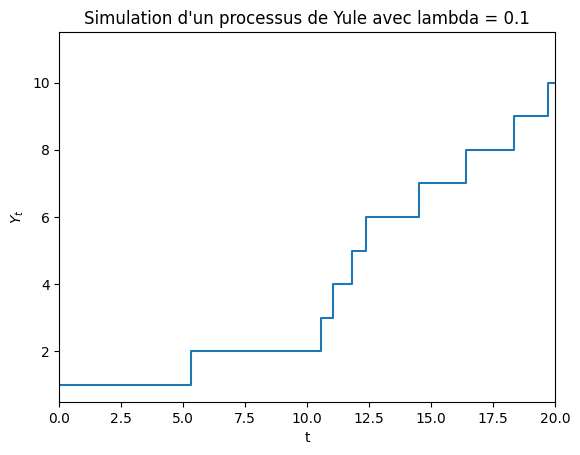

In [ ]:
Yule_A_step(l=0.1,t=20)

Néanmoins, cela ne reflète pas la lignée mise ne place, essayons de la dessiner en considérant la version naïve du processus de Yule.

Comme pour un arbre binaire de recherche dans un tableau à une dimension, les enfants d'un individu $i$ sont les éléments $2i$ et $2i + 1$. Considérons alors une file de priorité pour chaque individu avec comme priorité leur temps de mort.

In [ ]:
def Yule_graph_lignee(l,t):

    scale = 1/l

    t_queue = PriorityQueue()
    G = nx.DiGraph()

    t_queue.put((npr.exponential(scale),0))
    G.add_node('0')
    pos = {str(0):(0,0)}

    first = t_queue.get()

    p = 1
    Y = 1

    while first[0] < t:
        i0 = first[1]
        t0 = first[0]

        i1 = i0-p
        t1 = npr.exponential(scale) + first[0]
        t_queue.put((t1,i1))
        G.add_node(str(i1),birth = first[0])
        G.add_edge(str(i0),str(i1))
        pos[str(i1)] = (t0,i1)

        i2 = i0 + p
        t2 = npr.exponential(scale) + first[0]
        t_queue.put((t2,i2))
        G.add_node(str(i2),birth = first[0])
        G.add_edge(str(i0),str(i2))
        pos[str(i2)] = (t0,i2)

        first = t_queue.get()

        p /=2
        Y += 1

    fig, ax = plt.subplots(figsize=(12, 6))
    nx.draw(G,pos,ax,node_size=50, arrowsize=10)
    ax.tick_params(left=False, bottom=True, labelleft=False, labelbottom=True)
    plt.xlabel("t")
    plt.title(f"Arbre de lignée, Y={Y}")
    plt.axis('on')
    plt.vlines(x=t, ymin = -2, ymax = 2, color='r', label="temps d'arrêt")
    plt.legend()
    plt.show()

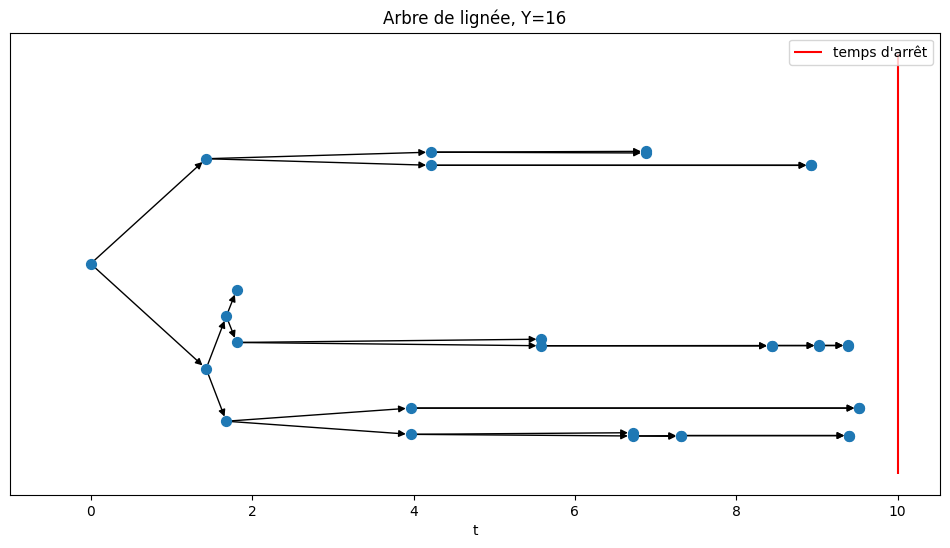

In [ ]:
Yule_graph_lignee(l = 0.2,t = 10)

### Question 1

La méthode permet donc de simuler très efficacement le processus : utilisons donc pour une méthode de Monte Carlo naïve en tentant d'estimer des événements rares $Y_t > A$ avec A grand ou $Y_t < A$ avec A petit.

#### Monte Carlo naïve

##### Fonctions

In [ ]:
def MC_naif_A_sup_A(l,t,A,N=int(1e6),horizontal_line_width=0.7):
    """Utilisation de la méthode Monte Carlo naïve avec méthode (A) pour déterminer P(Y_t>A)"""

    scale = 1/l

    #Affichage de la théorie
    A_cont = np.arange(min(A)-1,max(A)+2)
    plt.step(A_cont,1 - sps.geom.cdf(A_cont,np.exp(-l*t)), c = '#F97300', label='théorie',where='mid')

    #Calculs
    suivi_temps = np.zeros(len(A))
    for k,a in enumerate(A):
        suivi_temps[k] = time()
        Y = np.array([Yule_A(scale,t) for _ in range(N)])
        suivi_temps[k] = time() - suivi_temps[k]
        plot_confidence_interval(a,Y>a,horizontal_line_width=horizontal_line_width)

    #Affichage
    plt.legend()
    plt.grid()
    plt.title(f"Estimation de $P(Y_t > A)$ par Monte Carlo naïf \n $N = {N}, \lambda = {l}, t = {t}$")
    plt.xlabel("$A$")
    plt.ylabel("$P(Y_t>A)$")

    plt.figure()
    plt.title("Temps de calcul")
    plt.scatter(A,suivi_temps)
    plt.xlabel("A")
    plt.ylabel("Temps de calcul (secondes)")
    plt.grid()
    plt.show()

In [ ]:
def MC_naif_A_inf_A(l,t,A,N=int(1e6),horizontal_line_width=0.7):
    """Utilisation de la méthode Monte Carlo naïve avec méthode (A) pour déterminer P(Y_t<=A)"""

    scale = 1/l

    #Affichage de la théorie
    A_cont = np.arange(min(A)-1,max(A)+2)
    plt.figure()
    plt.step(A_cont,sps.geom.cdf(A_cont,np.exp(-l*t)), c = '#F97300', label='théorie',where='mid')

    #Calculs
    suivi_temps = np.zeros(len(A))
    for k,a in enumerate(A):
        suivi_temps[k] = time()
        Y = np.array([Yule_A(scale,t) for _ in range(N)])
        suivi_temps[k] = time() - suivi_temps[k]
        plot_confidence_interval(a,Y<=a,horizontal_line_width=horizontal_line_width)

    #Affichage
    plt.legend()
    plt.grid()
    plt.title(f"Estimation de $P(Y_t \leq A)$ par Monte Carlo naïf \n $N = {N}, \lambda = {l}, t = {t}$")
    plt.xlabel("$A$")
    plt.ylabel("$P(Y_t \leq A)$")

    plt.figure()
    plt.title("Temps de calcul")
    plt.scatter(A,suivi_temps)
    plt.xlabel("A")
    plt.ylabel("Temps de calcul (secondes)")
    plt.grid()
    plt.show()

##### Tests

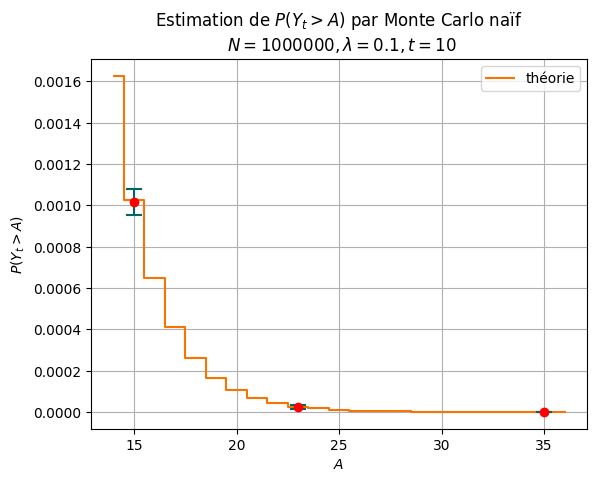

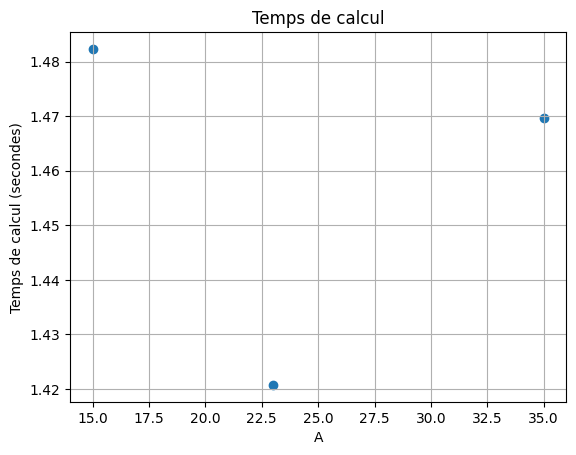

In [ ]:
MC_naif_A_sup_A(l=0.1,t=10,A=[15,23,35])

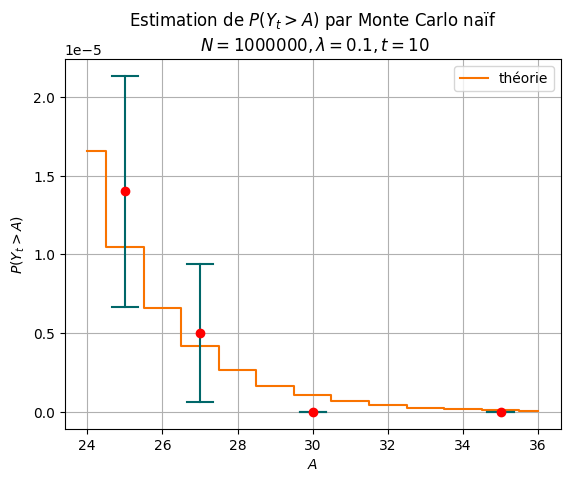

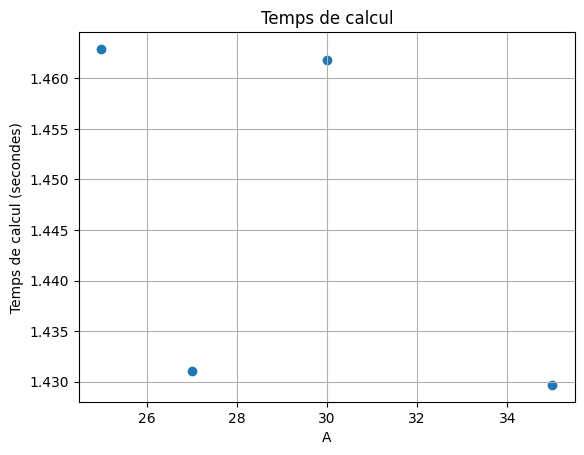

In [ ]:
MC_naif_A_sup_A(l=0.1,t=10,A=[25, 27, 30, 35])

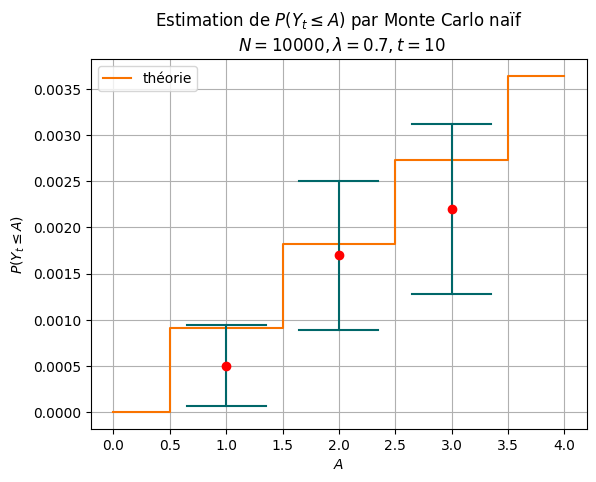

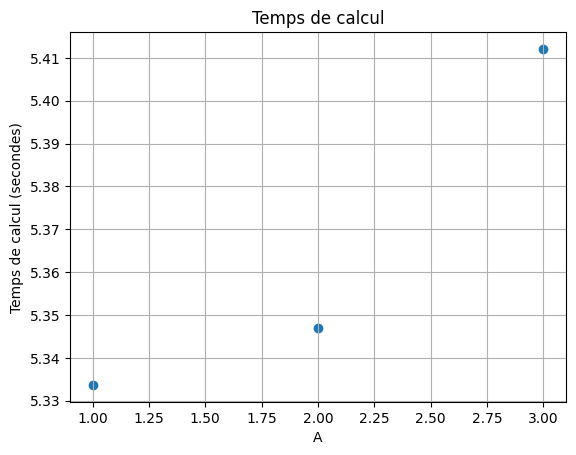

In [ ]:
MC_naif_A_inf_A(l=0.7,t=10,A=[3,2,1],N=int(1e4))

On remarque très rapidement les limites de la méthode naïve : les temps de calcul explosent dès que les événements se rarifient, et les intervalles de confiance sont bien trop larges.

#### Echantillonage d'importance

L'échantillonage d'importance serait alors une solution pour obtenir des résultats en un temps réduit, essayons-la :

##### Fonctions

In [ ]:
def IS_A_sup_diff_A(l, t, A, C, N = int(1e4), n_max=50000, horizontal_line_width=0.7):
    """Utilisation d'échantillonage d'importance avec méthode (A) pour déterminer P(Y_t>A)
    C est fixe
    Tableau de valeurs de A"""

    # Calcul de F(n) pour n jusqu'à n_max : F[n] = F(n+1)
    i = np.arange(1,n_max + 1)
    F = (i+C)/i
    F = np.log(F)
    F = np.cumsum(F)

    scale = 1/l

    #Affichage de la théorie
    plt.figure()
    A_cont = np.arange(min(A)-1,max(A)+2)
    plt.step(A_cont,1 - sps.geom.cdf(A_cont,np.exp(-l*t)), c = '#F97300', label='théorie',where='mid')

    #Calculs
    suivi_temps = np.zeros(len(A))
    for k,a in enumerate(A):
        suivi_temps[k] = time()
        Y = np.zeros(N, dtype='int')
        param = np.zeros(N)
        for j in range (N) :
            Y[j] = C+1
            # Chaque branche est indépendante de l'autre
            for _ in range (C+1) :
                Y[j]+=Yule_A(scale,t)-1 #On rajoute uniquement le nombre de morts

            param[j] = np.exp(-F[Y[j]-C-2]+l*C*t)

        suivi_temps[k] = time() - suivi_temps[k]

        plot_confidence_interval(a,(Y-C>a)*param,horizontal_line_width=horizontal_line_width)

    #Affichage
    plt.title(f"Estimation de $P(Y_t > A)$ par échantillonage d'importance \n $N = {N}, \lambda = {l}, t = {t}, C = {C}$")
    plt.xlabel("$A$")
    plt.ylabel("$P(Y_t>A)$")
    plt.legend()
    plt.grid()

    plt.figure()
    plt.title("Temps de calcul")
    plt.scatter(A,suivi_temps)
    plt.xlabel("A")
    plt.ylabel("Temps de calcul (secondes)")
    plt.grid()
    plt.show()

In [ ]:
def IS_A_sup_diff_C(l, t, A, C, N = int(1e4), n_max=50000, horizontal_line_width=0.7):
    """Utilisation d'échantillonage d'importance avec méthode (A) pour déterminer P(Y_t>A)
    A est fixe
    Tableau de valeurs de C"""

    scale = 1/l
    i = np.arange(1,n_max + 1)

    #Affichage de la théorie
    plt.figure()
    plt.hlines(y=1 - sps.geom.cdf(A,np.exp(-l*t)), xmin=min(C)-1,xmax=max(C)+1, color = '#F97300', label = 'théorie')

    #Calculs
    suivi_temps = np.zeros(len(C))
    for k,c in enumerate(C):
        # Calcul de F(n) pour n jusqu'à n_max : F[n] = F(n+1)
        F = (i+c)/i
        F = np.log(F)
        F = np.cumsum(F)

        suivi_temps[k] = time()
        Y = np.zeros(N, dtype='int')
        param = np.zeros(N)
        for j in range (N) :
            Y[j] = c+1
            # Chaque branche est indépendante de l'autre
            for _ in range (c+1) :
                Y[j]+=Yule_A(scale,t)-1 #On rajoute uniquement le nombre de morts

            param[j] = np.exp(-F[Y[j]-c-2]+l*c*t)
        suivi_temps[k] = time() - suivi_temps[k]

        plot_confidence_interval(c,(Y-c>A)*param,horizontal_line_width=horizontal_line_width)

    #Affichage
    plt.title(f"Estimation de $P(Y_t > A)$ par échantillonage d'importance \n $N = {N}, \lambda = {l}, t = {t}, A = {A}$")
    plt.xlabel("$C$")
    plt.ylabel("$P(Y_t>A)$")
    plt.legend()
    plt.grid()

    plt.figure()
    plt.title("Temps de calcul")
    plt.scatter(C,suivi_temps)
    plt.xlabel("C")
    plt.ylabel("Temps de calcul (secondes)")
    plt.grid()
    plt.show()

In [ ]:
def IS_A_inf_diff_A(l, t, A, C, N = int(1e4), n_max=50000, horizontal_line_width=0.7):
    """Utilisation d'échantillonage d'importance avec méthode (A) pour déterminer P(Y_t<=A)
    C est fixe
    Tableau de valeurs de A"""

    # Calcul de F(n) pour n jusqu'à n_max : F[n] = F(n+1)
    i = np.arange(1,n_max + 1)
    F = (i+C)/i
    F = np.log(F)
    F = np.cumsum(F)

    scale = 1/l

    #Affichage de la théorie
    plt.figure()
    A_cont = np.arange(min(A)-1,max(A)+2)
    plt.step(A_cont,sps.geom.cdf(A_cont,np.exp(-l*t)), c = '#F97300', label='théorie',where='mid')

    #Calculs
    suivi_temps = np.zeros(len(A))
    for k,a in enumerate(A):
        suivi_temps[k] = time()
        Y = np.zeros(N, dtype='int')
        param = np.zeros(N)
        for j in range (N) :
            Y[j] = C+1
            # Chaque branche est indépendante de l'autre
            for _ in range (C+1) :
                Y[j]+=Yule_A(scale,t)-1 #On rajoute uniquement le nombre de morts

            param[j] = np.exp(-F[Y[j]-C-2]+l*C*t)

        suivi_temps[k] = time() - suivi_temps[k]

        plot_confidence_interval(a,(Y-C<=a)*param,horizontal_line_width=horizontal_line_width)

    #Affichage
    plt.title(f"Estimation de $P(Y_t \leq A)$ par échantillonage d'importance \n $N = {N}, \lambda = {l}, t = {t}, C = {C}$")
    plt.xlabel("$A$")
    plt.ylabel("$P(Y_t \leq A)$")
    plt.legend()
    plt.grid()

    plt.figure()
    plt.title("Temps de calcul")
    plt.scatter(A,suivi_temps)
    plt.xlabel("A")
    plt.ylabel("Temps de calcul (secondes)")
    plt.grid()
    plt.show()

##### Tests

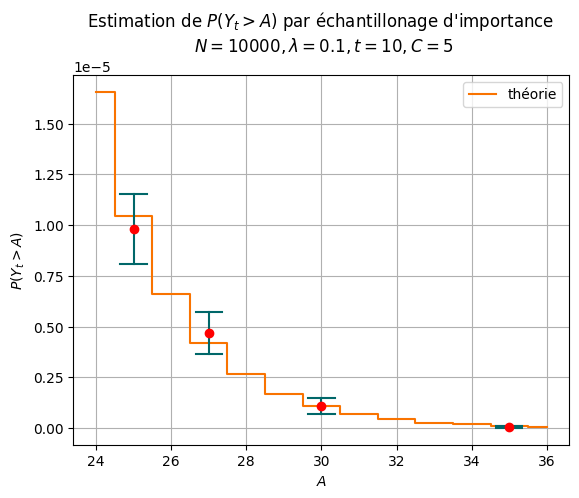

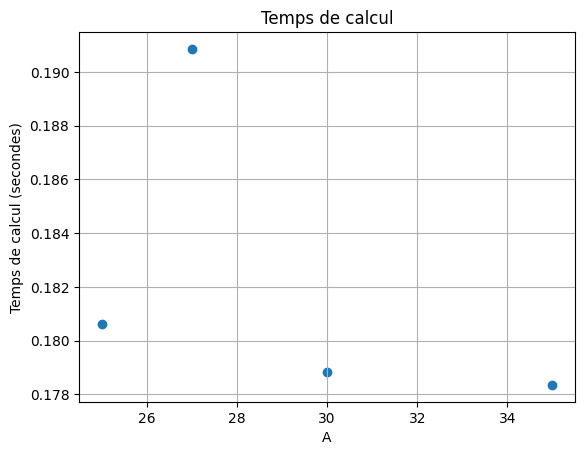

In [ ]:
IS_A_sup_diff_A(l=0.1, t=10, A=[25, 27, 30, 35], C=5)

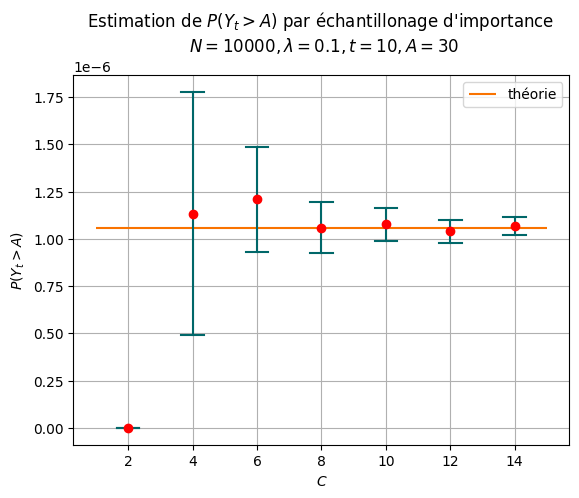

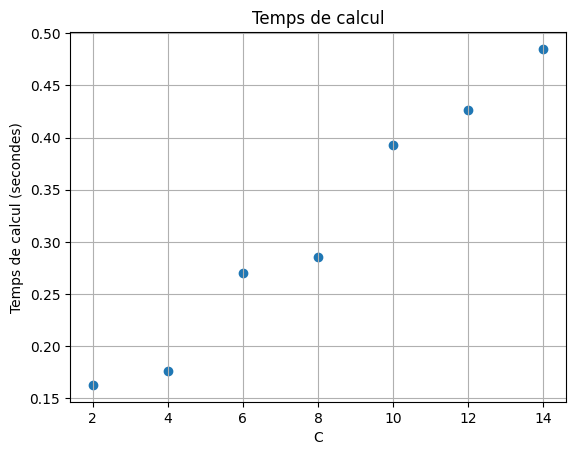

In [ ]:
IS_A_sup_diff_C(l=0.1, t=10, A=30, C=np.arange(2,15,2))

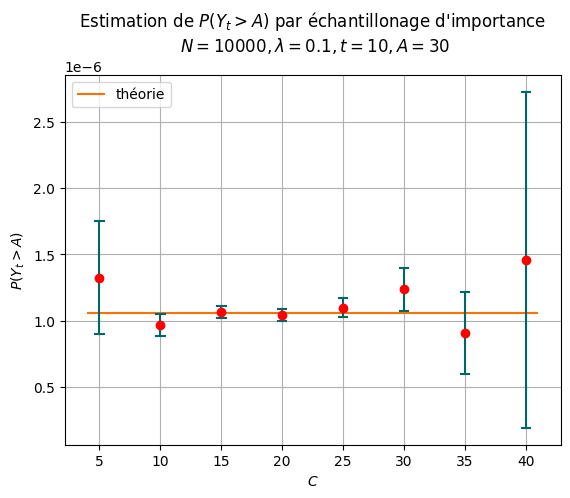

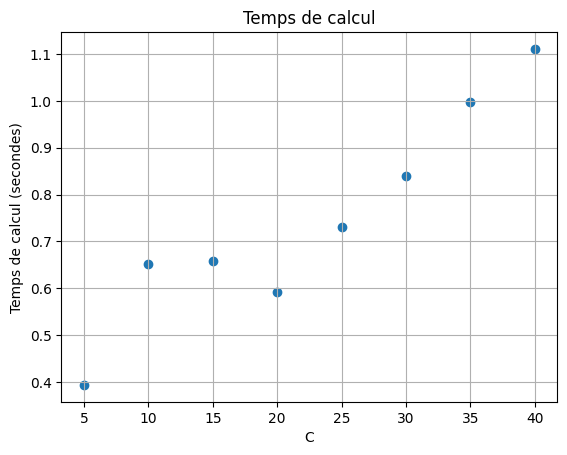

In [ ]:
IS_A_sup_diff_C(l=0.1, t=10, A=30, C=np.arange(5,45,5))

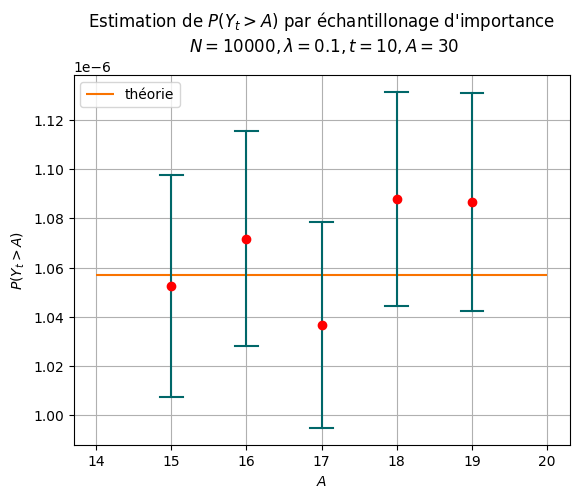

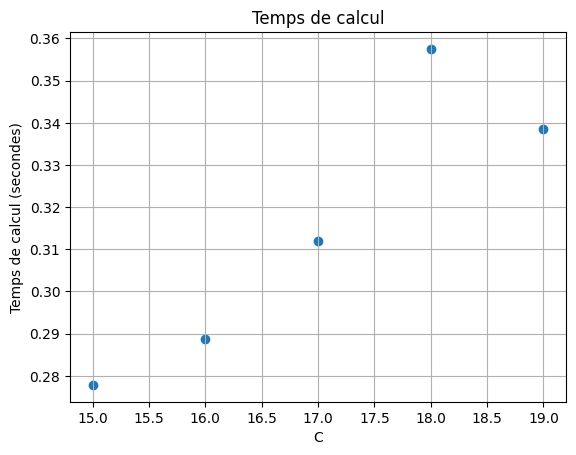

In [ ]:
IS_A_sup_diff_C(l=0.1, t=10, A=30, C=np.arange(15,20),horizontal_line_width=0.3)

Meilleur C = 15 : moins de temps de calcul pour aussi bonne précision

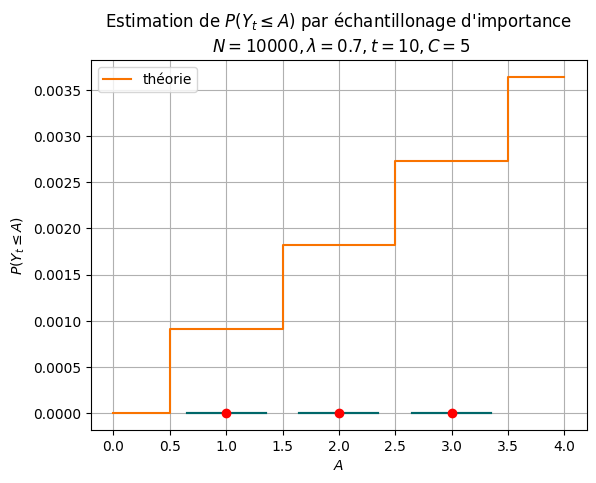

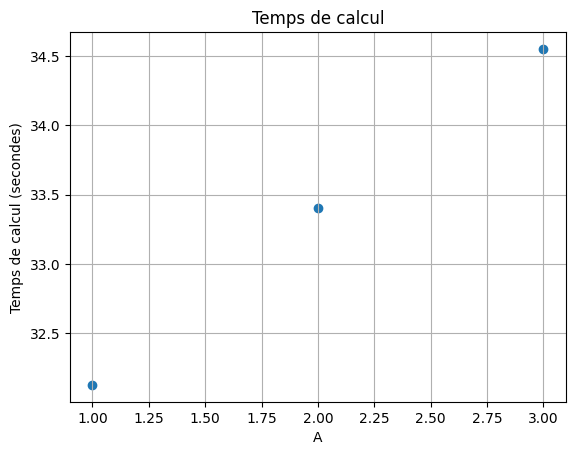

In [ ]:
IS_A_inf_diff_A(l=0.7, t=10, A=[1,2,3], C = 5, N = int(1e4))

Cette méthode d'échantillonage d'importance n'est pas pertinente pour $Y_t \leq A$ avec $A$ petit, car l'objectif est de multiplier le nombre d'individus le plus rapidement possible en augmentant C. Hors, le contraire est recherché dans ce cas.

In [ ]:
def important_sampling(alpha , l, A, t, N = 10000 ) :
     """Utilisation d'échantillonage d'importance en modifiant lambda représentant le taux de naissance avec méthode (A) pour déterminer P(Y_t<=A)
    C est fixe
    Tableau de valeurs de A"""

     mu = alpha*l
     s1 = 1/l
     s2 = 1/mu
     naissances = npr.exponential(scale = s2, size = (N,A))
     i = np.arange(1,A+1)
     naissances = naissances / i # temps de naissances, à chaque colonne il s'agit d'une exponentielle de paramère lambda*(j+1)
     childs_A = np.zeros(N) # temps au bout duquel on a A enfants
     paramètre = np.zeros(N)
     for j in range(N ) :
          childs_A[j] = np.sum(naissances[j])
          count = ( l/mu) ** A
          for k in range(A):
               count *= np.exp(-(l - mu) * (k + 1) * naissances[j][k])
          paramètre[j] = count

     probabilte = np.mean((childs_A < t) * paramètre)
     return probabilte

In [ ]:
A ,t,l, alpha = 25,10,0.1,2.5

print("Probabilité théorique : " + str( (1 - np.exp(-l * t))**(A)))
print(f"Pour A = {A}, on estime la probabilité que Y_t > A à {important_sampling(alpha, l,A,t)} ")

Probabilité théorique : 1.0471234469067592e-05
Pour A = 25, on estime la probabilité que Y_t > A à 1.5724675395143062e-05 


In [ ]:
def plot_errors_important_sampling_inf(alpha , l, A, t, N = 100000) :
    size = np.size (alpha)
    ecart_type_relative =   np.zeros(size)
    probabilites= np.zeros(size)
    for index in range (size ) :
        mu = alpha[index]*l
        s1 = 1/l
        s2 = 1/mu
        naissances = npr.exponential(scale = s2, size = (N,A))
        i = np.arange(1,A+1)
        naissances = naissances / i # temps de naissances, à chaque colonne il s'agit d'une exponentielle de paramère lambda*(j+1)
        childs_A = np.zeros(N) # temps au bout duquel on a A enfants
        paramètre = np.zeros(N)
        for j in range(N ) :
            childs_A[j] = np.sum(naissances[j])
            count = ( l/mu) ** A
            for k in range(A):
                count *= np.exp(-(l - mu) * (k + 1) * naissances[j][k])
            paramètre[j] = count

        probabilites[index] = np.mean((childs_A >= t) * paramètre)
        ecart_type = np.var((childs_A >= t) * paramètre)
        if probabilites[index] != 0 :
            ecart_type_relative[index] = (ecart_type)/probabilites[index]
        else :
            ecart_type_relative[index] = 0.25 ## valeur arbitrairement grande
    index_opt = np.argmin(ecart_type_relative[ecart_type_relative != 0])
    plt.plot(alpha,ecart_type_relative)
    plt.xlabel("alpha")
    plt.ylabel("Erreur relative")
    plt.title(f"Erreur relative en fonction de $alpha$ \n  $\lambda$ = {l}, A = {A} , t = {t}" )
    print(f"la meilleur approximaion qu'on a ait {probabilites[index_opt]}  ")
    print(f"le meilleur alpha qu'on a ait {alpha[index_opt]}  ")

    print (f"l'erreur relative est de {ecart_type_relative[index_opt]}")
    print("Probabilité théorique : " + str(1 - (1 - np.exp(-l * t))**(A)))


In [ ]:
def plot_important_sampling_inf(alpha , l, A, t, N = 100000) :
    size = np.size (A)
    probabilites= np.zeros(size)
    for index in range (size ) :
        mu = alpha*l
        s1 = 1/l
        s2 = 1/mu
        naissances = npr.exponential(scale = s2, size = (N,A[index]))
        i = np.arange(1,A[index]+1)
        naissances = naissances / i # temps de naissances, à chaque colonne il s'agit d'une exponentielle de paramère lambda*(j+1)
        childs_A = np.zeros(N) # temps au bout duquel on a A enfants
        paramètre = np.zeros(N)
        for j in range(N ) :
            childs_A[j] = np.sum(naissances[j])
            count = ( l/mu) ** A[index]
            for k in range(A[index]):
                count *= np.exp(-(l - mu) * (k + 1) * naissances[j][k])
            paramètre[j] = count

        probabilites[index] = np.mean((childs_A >= t) * paramètre)
    plt.plot(A,probabilites, label = "valeur prédite")
    plt.plot(A, 1 - (1 - np.exp(-l * t))**(A), label ="Valeur théorique")
    plt.xlabel("A")
    plt.ylabel("Probabilité")
    plt.legend()
    plt.title(f"Estimation des probabilités en fonction de $A$ \n  $\lambda$ = {l}, $alpha$ = {alpha} , t = {t}" )


la meilleur approximaion qu'on a ait 2.2694925589071726e-13  
le meilleur alpha qu'on a ait 0.09387755102040818  
l'erreur relative est de 2.087667032113304e-10
Probabilité théorique : 2.807754029277021e-13


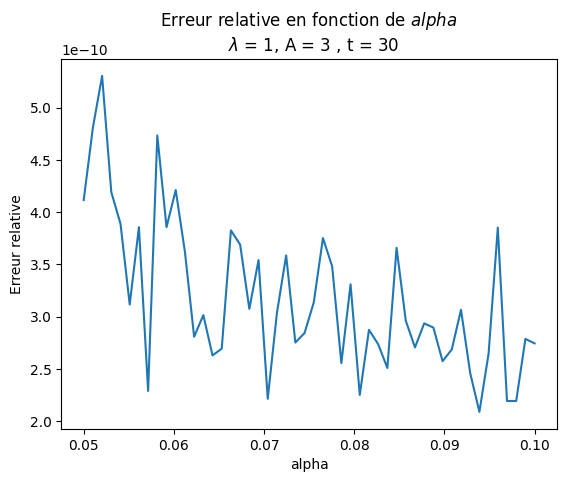

In [ ]:
A ,t,l, alpha = 3,30,1,np.linspace(0.05,0.1,50)
plot_errors_important_sampling_inf(alpha , l, A, t)



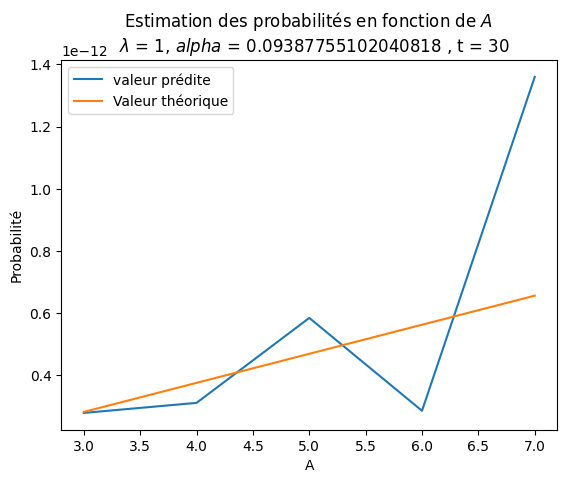

In [ ]:
A ,t,l, alpha = [3,4,5,6,7],30,1,0.09387755102040818
plot_important_sampling_inf(alpha , l, A, t)



In [ ]:
def plot_errors_important_sampling_sup(alpha , l, A, t, N = 100000) :
    size = np.size (alpha)
    ecart_type_relative =   np.zeros(size)
    probabilites= np.zeros(size)
    for index in range (size ) :
        mu = alpha[index]*l
        s1 = 1/l
        s2 = 1/mu
        naissances = npr.exponential(scale = s2, size = (N,A))
        i = np.arange(1,A+1)
        naissances = naissances / i # temps de naissances, à chaque colonne il s'agit d'une exponentielle de paramère lambda*(j+1)
        childs_A = np.zeros(N) # temps au bout duquel on a A enfants
        paramètre = np.zeros(N)
        for j in range(N ) :
            childs_A[j] = np.sum(naissances[j])
            count = ( l/mu) ** A
            for k in range(A):
                count *= np.exp(-(l - mu) * (k + 1) * naissances[j][k])
            paramètre[j] = count

        probabilites[index] = np.mean((childs_A < t) * paramètre)
        ecart_type = np.var((childs_A < t) * paramètre)
        if probabilites[index] != 0 :
            ecart_type_relative[index] = (ecart_type)/probabilites[index]
        else :
            ecart_type_relative[index] = 0.25 ## valeur arbitrairement grande
    index_opt = np.argmin(ecart_type_relative[ecart_type_relative != 0])
    plt.plot(alpha,ecart_type_relative)
    plt.xlabel("alpha")
    plt.ylabel("Erreur relative")
    plt.title(f"Erreur relative en fonction de $alpha$ \n  $\lambda$ = {l}, A = {A} , t = {t}" )
    print(f"la meilleur approximation qu'on a ait {probabilites[index_opt]}  ")
    print(f"le meilleur alpha qu'on a ait {alpha[index_opt]}  ")

    print (f"l'erreur relative est de {ecart_type_relative[index_opt]}")
    print("Probabilité théorique : " + str((1 - np.exp(-l * t))**(A)))


la meilleur approximation qu'on a ait 9.829469316924958e-06  
le meilleur alpha qu'on a ait 2.0555555555555554  
l'erreur relative est de 0.001724420855502878
Probabilité théorique : 1.0471234469067592e-05


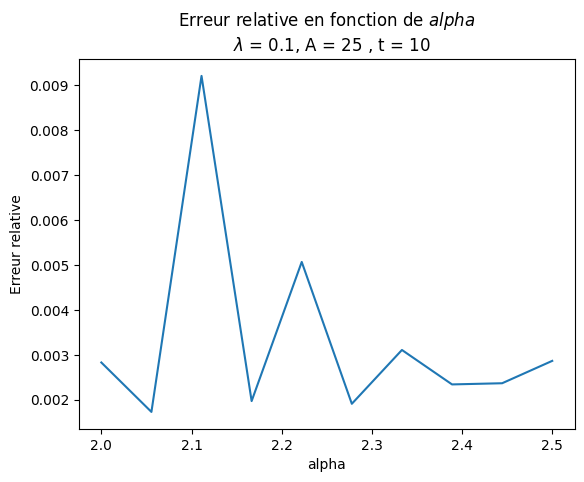

In [ ]:
A ,t,l, alpha = 25,10,0.1,np.linspace(2,2.5,10)
plot_errors_important_sampling_sup(alpha , l, A, t)


#### MCMC

In [ ]:
## Utilisation du MCMC
def pi(x, A, l):
    i = np.arange(1, A + 1)
    densities = l * i * np.exp(-l * i * x)
    return np.prod(densities)

def metropolis_hastings (minimum,départ,A,l) :
  samples = npr.normal(0, 1, size=A)
  temp=np.zeros(A)
  for i in range (A) :
      temp[i] = départ[i] + samples[i]
  if np.sum(temp) > minimum :
      alpha = min(pi(temp,A,l)/pi(départ,A,l),1)
  else :
      alpha = 0
  if npr.rand() < alpha :
      return temp
  return départ

def yule_splitting (A,t,l) :
    N=100
    M=100
    simulations = np.zeros((N,A))
    i= np.arange(A)
    i=i+1
    i=1/i
    for k in range (N) :
        E = npr.exponential(1/l,A)
        E=E*i
        simulations[k] = E
    S= np.array([np.sum(elem) for elem in simulations])
    x=np.min(S)
    index = np.argmin(S)
    J=0
    while (x<t) :
        J+=1
        départ = simulations[npr.randint(0,A)]
        for _ in range (M) :
            départ = metropolis_hastings(x,départ,A,l)
        simulations[index] = départ
        S[index] = np.sum(départ)
        x=np.min(S)
        index = np.argmin(S)
    return (1-1/N)**J

In [ ]:
A,t,l = 5,2,1
print (f"probabilité estimée : {yule_spl²itting(A,t,l)}")
print(f"La probabilité théorique : {1-(1 - np.exp(-l * t))**(A)}")

probabilité estimée : 0.3887839180742268
La probabilité théorique : 0.5166756358526352


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-13-74cdc88149f4>:16: RuntimeWarning: invalid value encountered in scalar divide
  proba = min(1, pi(temp, A, l) / pi(current_sample, A, l))


Generated samples: [[   1.            1.            1.            1.            1.        ]
 [   0.93887125    1.20434446    0.77286796    0.90421634    0.85818725]
 [   1.08859064    0.9911339     0.70257567    0.87301511    0.91177758]
 ...
 [  32.56948907  -46.40457296  -30.50875322 -121.50091001 -101.32523101]
 [  32.6819721   -46.30811887  -30.34301771 -121.47276314 -100.98037376]
 [  32.70760089  -46.07646111  -30.30379833 -121.50379868 -101.2910525 ]]


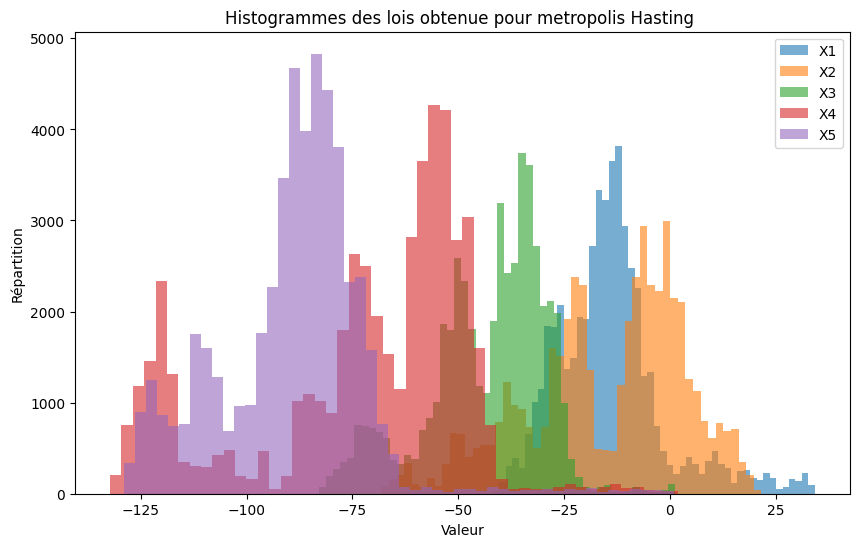

In [ ]:
#Mise en évidence de la vitesse de convergence (ce qui peut expliquer que le code ne marche pas)

def pi(x, A, l):
    i = np.arange(1, A + 1)
    densities = l * i * np.exp(-l * i * x)
    return np.prod(densities)

def densité_intermédiaire(x, sigma):
    return x + npr.normal(0, sigma, size=x.shape)

def metropolis_hastings(initial_sample, num_samples, A, l, sigma):
    current_sample = initial_sample
    simulations = [current_sample]
    for _ in range(num_samples):
        temp = densité_intermédiaire(current_sample, sigma)
        proba = min(1, pi(temp, A, l) / pi(current_sample, A, l))
        if npr.rand() < proba:
            current_sample =temp
        simulations.append(current_sample)
    return np.array(simulations)

A = 5
l = 1
initial_sample = np.ones(A)
num_samples = 50000
sigma = 0.25


samples = metropolis_hastings(initial_sample, num_samples, A, l, sigma)

print("Generated samples:", samples)



plt.figure(figsize=(10, 6))
for i in range(A):
    plt.hist(samples[:, i], bins=50, alpha=0.6, label=f'X{i+1}')
plt.legend()
plt.title("Histogrammes des lois obtenue pour metropolis Hasting ")
plt.xlabel("Valeur")
plt.ylabel("Répartition")
plt.show()


In [ ]:
def yule_splitting_2(A,t,s, niveaux) :
    N=1000
    probabilités = np.zeros((niveaux, A)) #représente P(Yti=k| Yti<A) pour k<A
    simulations =np.array( [Yule_A(s, t/niveaux) for i in range (N)])
    totale = np.sum(simulations<=A)
    proba_finale= 1

    for i in range (A) :
        probabilités[0][i] =    np.sum(simulations==i+1)/totale

    for level in range(1,niveaux) :

        for k in range (1,A+1) :
            simulations = np.zeros(N)
            for j in range (N) :
                count = k
                for _ in range(count):
                    count += Yule_A(s, t / niveaux) - 1
                simulations[j] = count
            for i in range (A) :
                probabilités[level][i] +=( np.sum(simulations==i+1)/N)*probabilités[level-1][k-1] ##P(Y_level =i| Y_level-1<=A)
        temp = np.sum(probabilités[level])
        proba_finale*=temp
        probabilités[level ] = probabilités[level]/np.sum(probabilités[level])
    temp = 0
    for k in range (1,A+1) :
        simulations = np.zeros(N)
        for j in range (N) :
                count = k
                for _ in range(count):
                    count += Yule_A(s, t / niveaux) - 1
                simulations[j] = count
        temp += (np.sum(simulations<=A)/N)*probabilités[niveaux-1][k-1]
    return proba_finale*temp



In [ ]:
l = 1.0
t = 10
n_levels = 200
A = 3
print(f"Pour A = {A}, on estime la probabilité que Y_t <= A à {yule_splitting_2(A,t,l,n_levels)}")
print("Probabilité théorique : " + str(1 - (1 - np.exp(-l * t))**(A )))


Pour A = 3, on estime la probabilité que Y_t <= A à 0.00012682065141338228
Probabilité théorique : 0.00013619360592020957


In [ ]:
def MC_splitting_E_inf_A(l,t,A,niveaux = 100 ,N=int(10), horizontal_line_width=0.7):
    """Utilisation de la méthode de splitting avec méthode (A) pour déterminer P(Y_t<=A)"""

    param = np.exp(l*t) - 1

    X = np.arange(min(A)-1,max(A)+2)
    plt.step(X,sps.geom.cdf(X,np.exp(-l*t)), c = '#F97300', label='théorie',where='mid')

    #Calculs
    suivi_temps = np.zeros(len(A))
    probas = []
    proba_max = []
    proba_mi = []
    for k,a in enumerate(A):
        suivi_temps[k] = time()
        Y = np.array([yule_splitting_2(a,t,1/l, niveaux) for _ in range(N)])
        suivi_temps[k] = time() - suivi_temps[k]
        probas.append(np.mean(Y))
        proba_max.append(np.max(Y))
        proba_mi.append(np.min(Y))

    #Affichage
    plt.plot(A,probas)
    plt.fill_between(A, proba_mi, proba_max, color='gray', alpha=0.5)
    plt.legend()
    plt.grid()
    plt.title(f"Estimation de $P(Y_t \leq A)$ par splitting \n $N = {N}, \lambda = {l}, t = {t}$")
    plt.xlabel("$A$")
    plt.ylabel("$P(Y_t \leq A)$")

    plt.figure()
    plt.title("Temps de calcul")
    plt.scatter(A,suivi_temps)
    plt.xlabel("A")
    plt.ylabel("Temps de calcul (secondes)")
    plt.grid()
    plt.show()

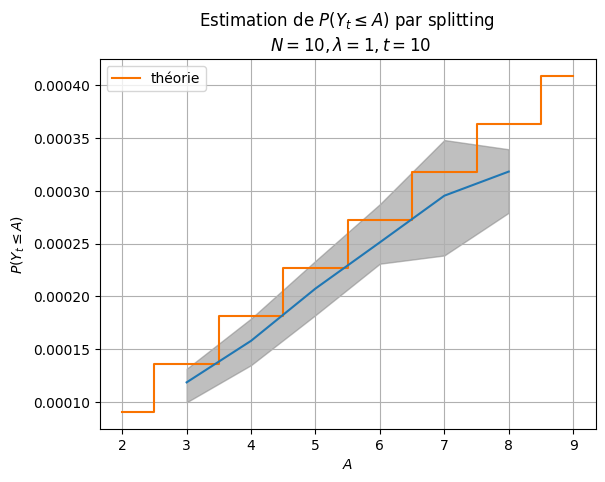

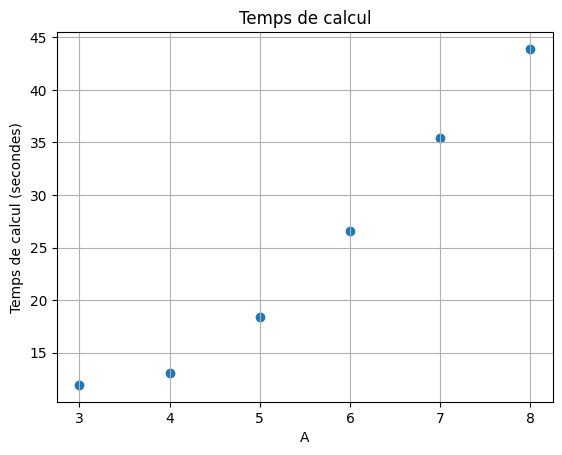

In [ ]:
MC_splitting_E_inf_A(l=1, t=10, A=[3,4,5,6,7,8])

### Question 2

##### Fonctions

In [ ]:
def conv_loi(l,T,N=int(1e3)):
    scale = 1/l

    for t in T:
        param = np.exp(-l*t)
        E = np.array([Yule_A(scale,t)*param for _ in range(N)])
        plt.hist(E, bins = 'auto', density = True, label = f'Répartition pour t = {t}', alpha = 0.5)

    x = np.linspace(0,max(E))
    plt.plot(x,sps.expon.pdf(x), label = 'Densité de loi exponentielle de paramètre 1')
    plt.legend()
    plt.title(f"Convergence en loi de $Y_t$ $exp(- \lambda t)$ \n $\lambda$ = {l}, t = {t}")
    plt.show()


In [ ]:
def conv_ps(l,t,nb=6,N=int(1e3)):
    scale = 1/l

    for _ in range (nb) :
        T = np.linspace(0,t,50)
        Y = fct_Yule_A(scale, T)
        y=np.exp(-T)*Y
        plt.plot(T,y)
    plt.title(f"Convergence presque sure de $Y_t$ $exp(- \lambda t)$ \n $\lambda$ = {l}")
    plt.xlabel("t")
    plt.ylabel("$Y_t$ $exp(- \lambda t)$")
    plt.show()

##### Tests


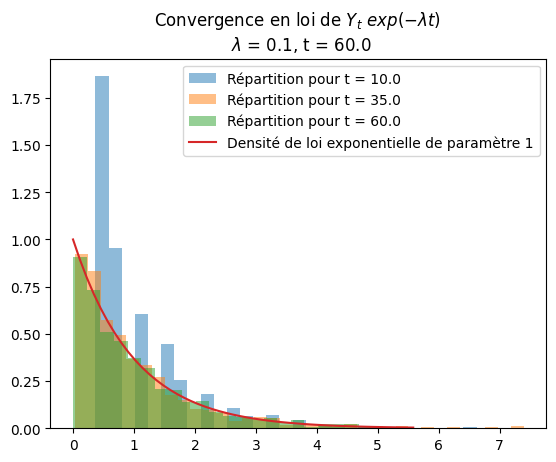

In [ ]:
conv_loi(l=0.1,T=np.linspace(10,60,3))

La densité pour t = 10 semble mal normalisée à cause des intervalles de répartition pour l'histogramme.

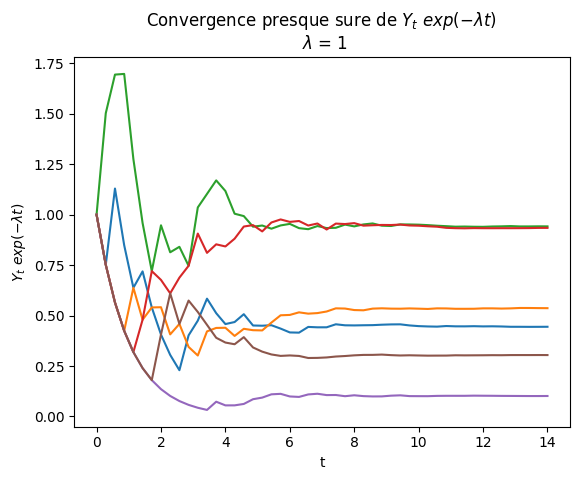

In [ ]:
conv_ps(l=1,t=14)

### Etude de la méthode (E)

In [ ]:
def Yule_E(param):
    # Processus de Poisson + 1
    t = npr.exponential(1)* param
    return 1 + npr.poisson(lam=t)

#### Etude par Monte Carlo naïve

On évalue la méthode à temps fixé final, donc le processus de Poisson revient à tirer une loi de Poisson :

##### Fonctions

In [ ]:
def MC_naif_E_sup_A(l,t,A,N=int(1e6),horizontal_line_width=0.7):
    """Utilisation de la méthode Monte Carlo naïve avec méthode (E) pour déterminer P(Y_t>A)"""

    param = np.exp(l*t) - 1

    #Affichage de la théorie
    A_cont = np.arange(min(A)-1,max(A)+2)
    plt.step(A_cont,1 - sps.geom.cdf(A_cont,np.exp(-l*t)), c = '#F97300', label='théorie',where='mid')

    #Calculs
    suivi_temps = np.zeros(len(A))
    for k,a in enumerate(A):
        suivi_temps[k] = time()
        Y = np.array([Yule_E(param) for _ in range(N)])
        suivi_temps[k] = time() - suivi_temps[k]
        plot_confidence_interval(a,Y>a,horizontal_line_width=horizontal_line_width)

    #Affichage
    plt.legend()
    plt.grid()
    plt.title(f"Estimation de $P(Y_t > A)$ par Monte Carlo naïf \n $N = {N}, \lambda = {l}, t = {t}$")
    plt.xlabel("$A$")
    plt.ylabel("$P(Y_t>A)$")

    plt.figure()
    plt.title("Temps de calcul")
    plt.scatter(A,suivi_temps)
    plt.xlabel("A")
    plt.ylabel("Temps de calcul (secondes)")
    plt.grid()
    plt.show()

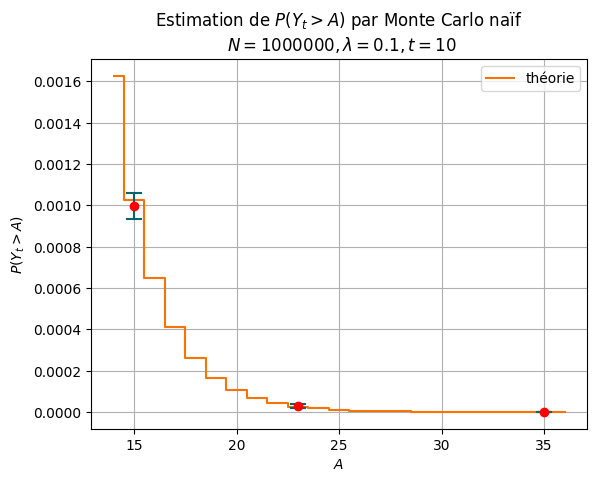

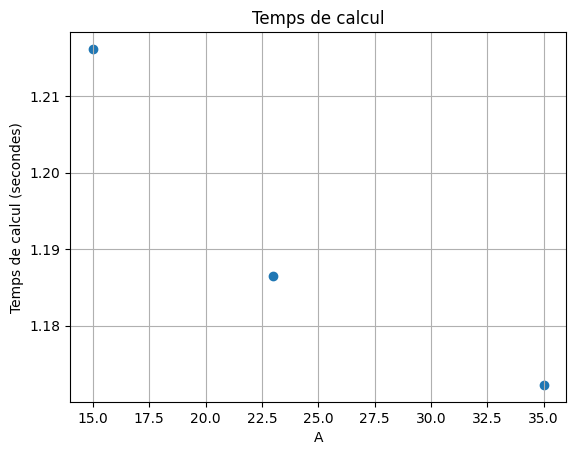

In [ ]:
MC_naif_E_sup_A(l=0.1, t=10, A=[15,23,35])

In [ ]:
def MC_naif_E_inf_A(l,t,A,N=int(1e6),horizontal_line_width=0.7):
    """Utilisation de la méthode Monte Carlo naïve avec méthode (E) pour déterminer P(Y_t<=A)"""

    param = np.exp(l*t) - 1

    #Affichage de la théorie
    A_cont = np.arange(min(A)-1,max(A)+2)
    plt.step(A_cont,sps.geom.cdf(A_cont,np.exp(-l*t)), c = '#F97300', label='théorie',where='mid')

    #Calculs
    suivi_temps = np.zeros(len(A))
    for k,a in enumerate(A):
        suivi_temps[k] = time()
        Y = np.array([Yule_E(param) for _ in range(N)])
        suivi_temps[k] = time() - suivi_temps[k]
        plot_confidence_interval(a,Y<=a,horizontal_line_width=horizontal_line_width)

    #Affichage
    plt.legend()
    plt.grid()
    plt.title(f"Estimation de $P(Y_t \leq A)$ par Monte Carlo naïf \n $N = {N}, \lambda = {l}, t = {t}$")
    plt.xlabel("$A$")
    plt.ylabel("$P(Y_t \leq A)$")

    plt.figure()
    plt.title("Temps de calcul")
    plt.scatter(A,suivi_temps)
    plt.xlabel("A")
    plt.ylabel("Temps de calcul (secondes)")
    plt.grid()
    plt.show()

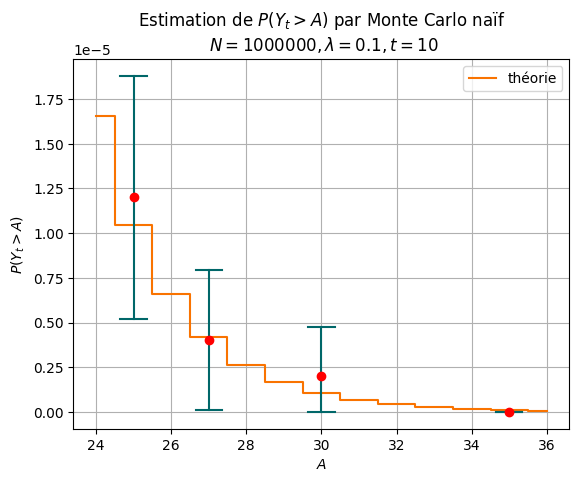

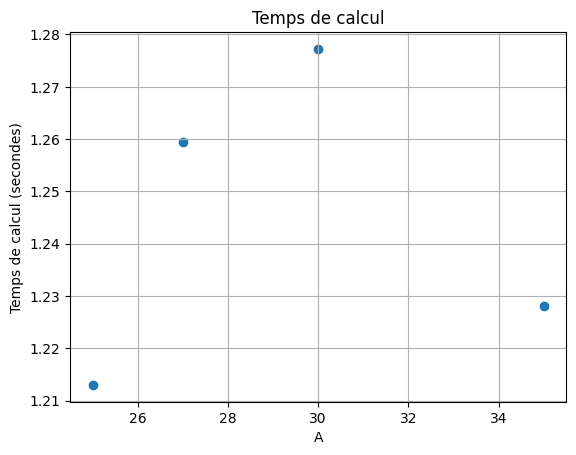

In [ ]:
MC_naif_E_sup_A(l=0.1,t=10,A=[25, 27, 30, 35])

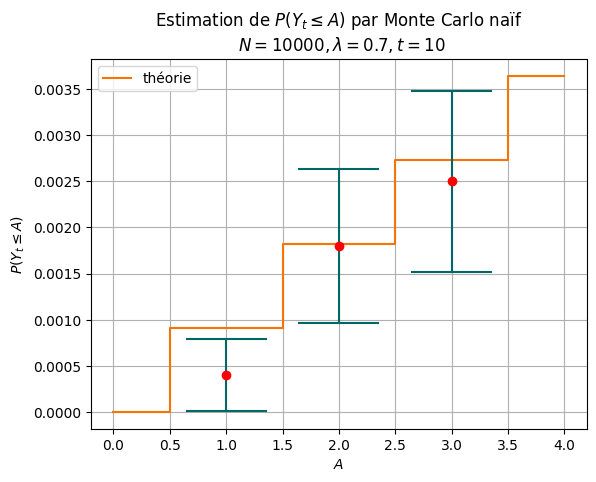

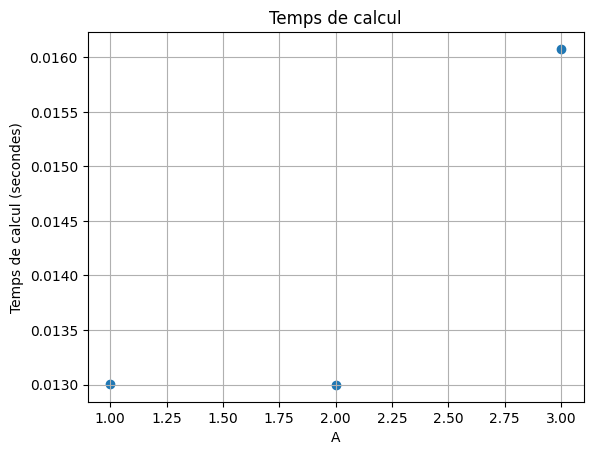

In [ ]:
MC_naif_E_inf_A(l=0.7,t=10,A=[3,2,1],N=int(1e4))

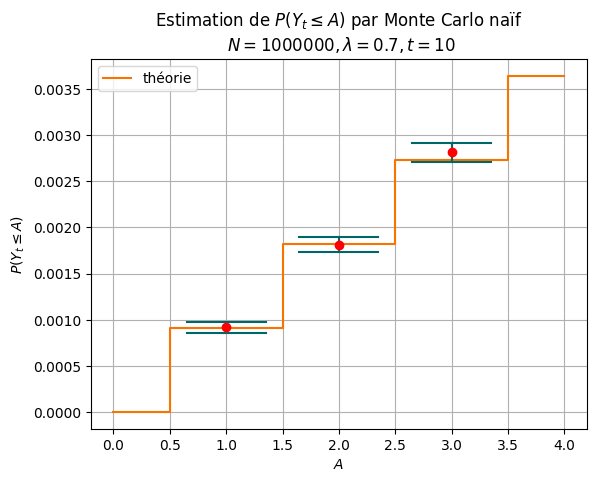

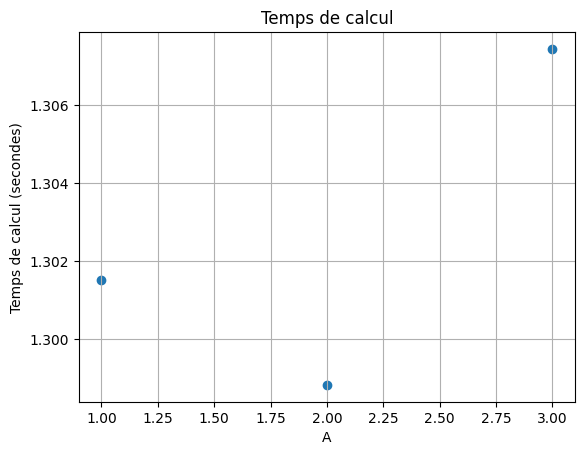

In [ ]:
MC_naif_E_inf_A(l=0.7,t=10,A=[3,2,1],N=int(1e6))

#### Etude par échantillonage d'importance

##### Fonctions

In [ ]:
def IS_E_sup_diff_A(l, t, A, C, N = int(1e4), n_max=50000, horizontal_line_width=0.7):
    """Utilisation d'échantillonage d'importance avec méthode (E) pour déterminer P(Y_t>A)
    C est fixe
    Tableau de valeurs de A"""

    # Calcul de F(n) pour n jusqu'à n_max : F[n] = F(n+1)
    i = np.arange(1,n_max + 1)
    F = (i+C)/i
    F = np.log(F)
    F = np.cumsum(F)
    parametre = np.exp(l*t) - 1

    param = np.exp(l*t) - 1

    #Affichage de la théorie
    plt.figure()
    A_cont = np.arange(min(A)-1,max(A)+2)
    plt.step(A_cont,1 - sps.geom.cdf(A_cont,np.exp(-l*t)), c = '#F97300', label='théorie',where='mid')

    #Calculs
    suivi_temps = np.zeros(len(A))
    for k,a in enumerate(A):
        suivi_temps[k] = time()
        Y = np.zeros(N, dtype='int')
        param = np.zeros(N)
        for j in range (N) :
            Y[j] = C+1
            # Chaque branche est indépendante de l'autre
            for _ in range (C+1) :
                Y[j]+=Yule_E(parametre)-1 #On rajoute uniquement le nombre de morts

            param[j] = np.exp(-F[Y[j]-C-2]+l*C*t)

        suivi_temps[k] = time() - suivi_temps[k]

        plot_confidence_interval(a,(Y-C>a)*param,horizontal_line_width=horizontal_line_width)

    #Affichage
    plt.title(f"Estimation de $P(Y_t > A)$ par échantillonage d'importance \n $N = {N}, \lambda = {l}, t = {t}, C = {C}$")
    plt.xlabel("$A$")
    plt.ylabel("$P(Y_t>A)$")
    plt.legend()
    plt.grid()

    plt.figure()
    plt.title("Temps de calcul")
    plt.scatter(A,suivi_temps)
    plt.xlabel("A")
    plt.ylabel("Temps de calcul (secondes)")
    plt.grid()
    plt.show()

In [ ]:
def IS_E_sup_diff_C(l, t, A, C, N = int(1e4), n_max=50000, horizontal_line_width=0.7):
    """Utilisation d'échantillonage d'importance avec méthode (E) pour déterminer P(Y_t>A)
    A est fixe
    Tableau de valeurs de C"""

    parametre = np.exp(l*t) - 1
    i = np.arange(1,n_max + 1)

    #Affichage de la théorie
    plt.figure()
    plt.hlines(y=1 - sps.geom.cdf(A,np.exp(-l*t)), xmin=min(C)-1,xmax=max(C)+1, color = '#F97300', label = 'théorie')

    #Calculs
    suivi_temps = np.zeros(len(C))
    for k,c in enumerate(C):
        # Calcul de F(n) pour n jusqu'à n_max : F[n] = F(n+1)
        F = (i+c)/i
        F = np.log(F)
        F = np.cumsum(F)

        suivi_temps[k] = time()
        Y = np.zeros(N, dtype='int')
        param = np.zeros(N)
        for j in range (N) :
            Y[j] = c+1
            # Chaque branche est indépendante de l'autre
            for _ in range (c+1) :
                Y[j]+=Yule_E(parametre)-1 #On rajoute uniquement le nombre de morts

            param[j] = np.exp(-F[Y[j]-c-2]+l*c*t)
        suivi_temps[k] = time() - suivi_temps[k]

        plot_confidence_interval(c,(Y-c>A)*param,horizontal_line_width=horizontal_line_width)

    #Affichage
    plt.title(f"Estimation de $P(Y_t > A)$ par échantillonage d'importance \n $N = {N}, \lambda = {l}, t = {t}, A = {A}$")
    plt.xlabel("$C$")
    plt.ylabel("$P(Y_t>A)$")
    plt.legend()
    plt.grid()

    plt.figure()
    plt.title("Temps de calcul")
    plt.scatter(C,suivi_temps)
    plt.xlabel("C")
    plt.ylabel("Temps de calcul (secondes)")
    plt.grid()
    plt.show()

In [ ]:
def IS_E_inf_diff_A(l, t, A, C, N = int(1e4), n_max=50000, horizontal_line_width=0.7):
    """Utilisation d'échantillonage d'importance avec méthode (E) pour déterminer P(Y_t<=A)
    C est fixe
    Tableau de valeurs de A"""

    # Calcul de F(n) pour n jusqu'à n_max : F[n] = F(n+1)
    i = np.arange(1,n_max + 1)
    F = (i+C)/i
    F = np.log(F)
    F = np.cumsum(F)

    parametre = np.exp(l*t) - 1

    #Affichage de la théorie
    plt.figure()
    A_cont = np.arange(min(A)-1,max(A)+2)
    plt.step(A_cont,sps.geom.cdf(A_cont,np.exp(-l*t)), c = '#F97300', label='théorie',where='mid')

    #Calculs
    suivi_temps = np.zeros(len(A))
    for k,a in enumerate(A):
        suivi_temps[k] = time()
        Y = np.zeros(N, dtype='int')
        param = np.zeros(N)
        for j in range (N) :
            Y[j] = C+1
            # Chaque branche est indépendante de l'autre
            for _ in range (C+1) :
                Y[j]+=Yule_E(parametre)-1 #On rajoute uniquement le nombre de morts

            param[j] = np.exp(-F[Y[j]-C-2]+l*C*t)

        suivi_temps[k] = time() - suivi_temps[k]

        plot_confidence_interval(a,(Y-C<=a)*param,horizontal_line_width=horizontal_line_width)

    #Affichage
    plt.title(f"Estimation de $P(Y_t \leq A)$ par échantillonage d'importance \n $N = {N}, \lambda = {l}, t = {t}, C = {C}$")
    plt.xlabel("$C$")
    plt.ylabel("$P(Y_t \leq A)$")
    plt.legend()
    plt.grid()

    plt.figure()
    plt.title("Temps de calcul")
    plt.scatter(A,suivi_temps)
    plt.xlabel("A")
    plt.ylabel("Temps de calcul (secondes)")
    plt.grid()
    plt.show()

##### Tests

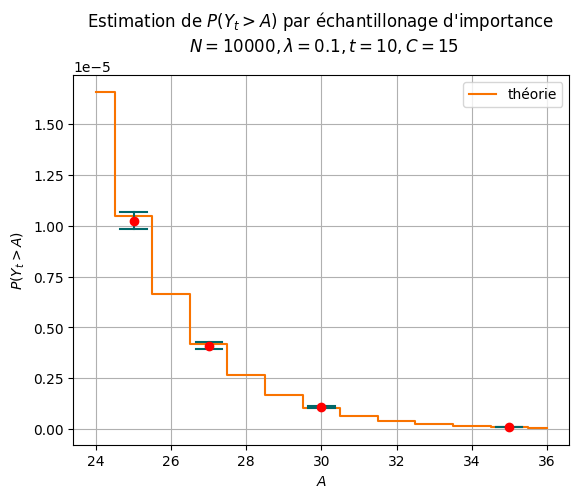

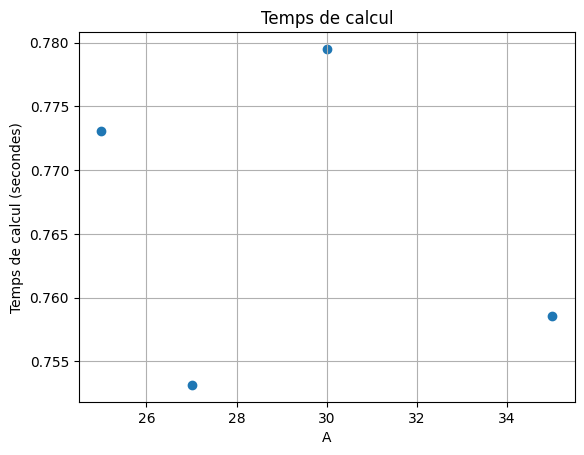

In [ ]:
IS_E_sup_diff_A(l=0.1, t=10, A=[25, 27, 30, 35], C=15)

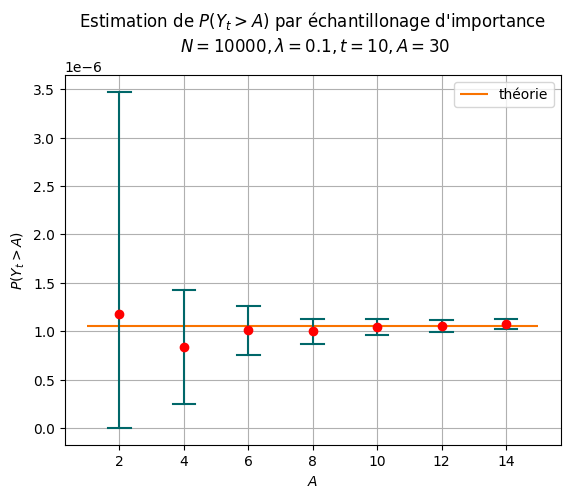

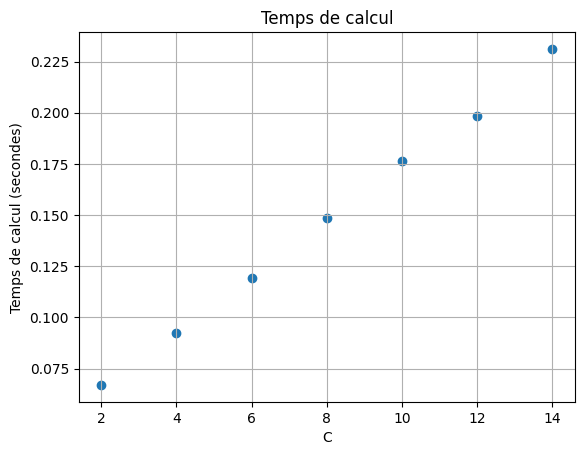

In [ ]:
IS_E_sup_diff_C(l=0.1, t=10, A=30, C=np.arange(2,15,2))

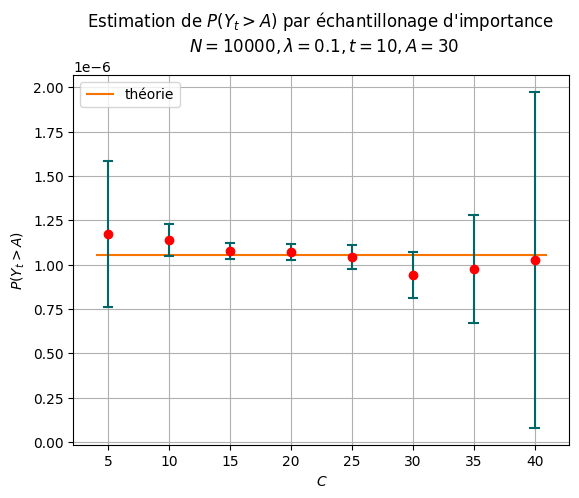

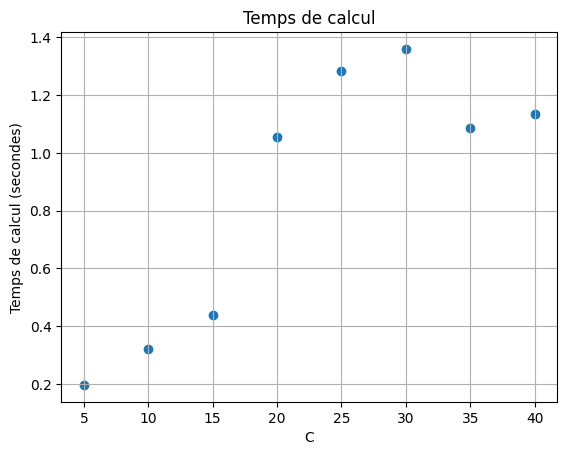

In [ ]:
IS_E_sup_diff_C(l=0.1, t=10, A=30, C=np.arange(5,45,5))

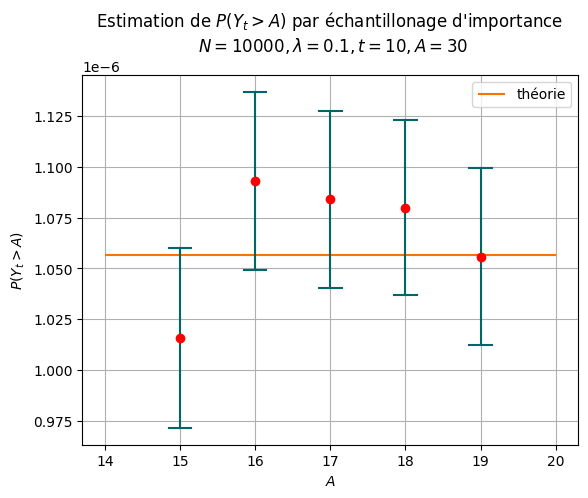

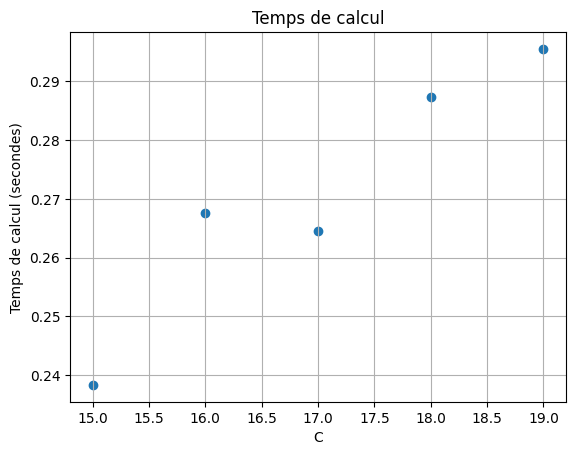

In [ ]:
IS_E_sup_diff_C(l=0.1, t=10, A=30, C=np.arange(15,20),horizontal_line_width=0.3)

On retombe bien sur les mêmes résultats, avec de très légers changements

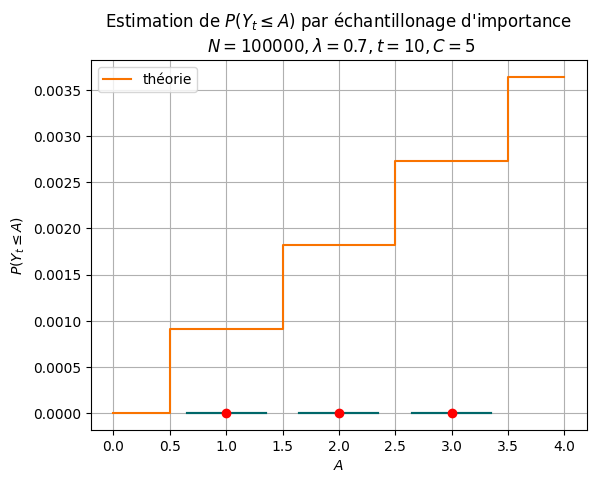

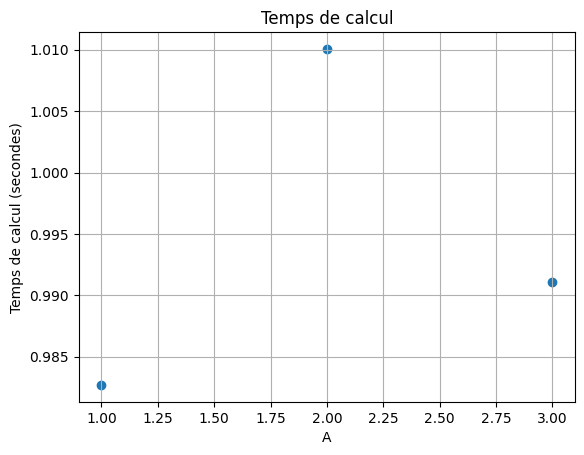

In [ ]:
IS_E_inf_diff_A(l=0.7, t=10, A=[1,2,3], C = 5, N = int(1e5))

## Partie 2

Essayons de montrer qu'il s'agit d'une marche aléatoire. Pour cela fixons $(T)_{i \in \mathbb{N}}$ une suite de v.a.i.i.d de loi exponentielle de paramètre 1, ainsi que $(\tau)_{i \in \mathbb{N}}$ une suite de v.a.i.i.d de loi exponentielle de paramètre $\lambda$. On note alors pour $n \in \mathbb{N}$ $X_n = \sum_{i=1}^{n} T_i $ et $Y_n = \sum_{i=1}^{n} \tau _i$. ON a alors que $(X_i)_{i \in \mathbb{N}}$ représentent les temps d'avancée des prédateurs tandis que $(Y_i)_{i \in \mathbb{N}}$ représentent ceux des proies. Dès lors pour calculer pour $n \in \mathbb{N}$ pour calculer $P(S_{n+1}-S_n = -1) $, on peut conditionner en réordonnant $(Y_i)_{i \in \mathbb{N}}$ et $(X_i)_{i \in \mathbb{N}}$ selon l'ordre croissant. Cet ordre ne dépend en faite que du temps de la dernière avancée de la proie. Notons $j$ le dernier temps dans lequel une proie a avancé. On a dispose alors de $k$ et de $m$ tq alors $P(S_{n+1}-Sn = -1| X_j < Y_k < \dots < Y_{k+m-1}) = P(X_{j+1}< Y_{k+m}|  X_j < Y_k < \dots < Y_{k+m-1}) $ (on n'est pas obligé de conditionner par rapport aux événements d'avant car ils ne sont pas pertinents). Or on a $ P(X_{j+1}< Y_{k+m}|  X_j < Y_k < \dots < Y_{k+m-1}) =  P(X_{j+1}-Xj< Y_{k+m} -X _j |  0 < Y_k -X_j < \dots < Y_{k+m-1} - X_j) = P(X_{j+1}-Y_{k+m-1}< Y_{k+m} -Y_{k+m-1} |   0< Y_{k+m-1}-X_j < X_{j+1}-X_j)$
or  $ X_{j+1}-X_j$ suit une loi exponentielle de paramètre 1 elle est alors sans mémoire. Dès lors, $ X_{j+1}-Y_{k+m-1} = X_{j+1}-X_j-(Y_{k+m-1}-X_j)$ sachant $0< Y_{k+m-1}-X_j < X_{j+1}-X_j$ suit aussi une loi exponentielle de paramètre 1, ie il a la même loi que $T_1$. Ainsi on a $P(S_{n+1}-Sn = -1| X_j < Y_k < \dots < Y_{k+m-1}) = P(T_1< Y_{k+m} -Y_{k+m-1} ) = P (T_1 < \tau _1)$  

On vient de montrer que notre probabilité est indépendante de l'ordre des $(Y_i)_{i \in \mathbb{N}}$ et $(X_i)_{i \in \mathbb{N}}$, donc $ P(S_{n+1}-S_n = -1) =  P (T_1 < \tau _1) $. On dispose alors d'une marche aléatoire de paramètre $P (T_1 >   \tau _1) = \frac{\lambda}{\lambda+1} $

In [ ]:
def Sn(scale,T):
    """Méthode naïve pour le calcul de S_n au bout d'un temps T"""
    S = 1
    t_born = npr.exponential(scale)
    t_death = npr.exponential(1)
    t = min(t_born,t_death)
    while S != 0 and t < T:
        if t_born > t_death:
            S-=1
            t_death = t + npr.exponential(1)
        else:
            S+=1
            t_born = t + npr.exponential(scale)
        t = min(t_born,t_death)
    return S


### Etude de $p(\lambda)$

##### Fonctions

In [ ]:
def Sn_plot_start_N(l,start,stop,nb=100,plot=True):
    """Trace l'évolution de (S_n) dans le temps à partir de S_0 = start.
    Le tracé s'arrête dès que S_n = 0 ou S_n = stop
    plot = False : affiche uniquement la proportion de S_n atteignant 0"""
    count0 = 0
    scale = 1/l
    for _ in tqdm(range(nb)):
        S_hist = [start]
        S = start
        t_hist = [0]
        t_born = npr.exponential(scale)
        t_death = npr.exponential(1)
        t = min(t_born,t_death)
        while S != 0 and S != stop:
            t_hist.append(t)
            if t_born > t_death:
                S-=1
                t_death = t + npr.exponential(1)
            else:
                S+=1
                t_born = t + npr.exponential(scale)
            t = min(t_born,t_death)
            S_hist.append(S)
        if S==0:
            count0 +=1

        if plot:
            plt.step(range(1,len(S_hist)+1),S_hist,where='post')

    if plot:
        plt.title(f"Trajectoires de $(S_n)$ avec $S_0 = ${start} \n $\lambda$ = {l}")
        plt.xlabel("n")
        plt.ylabel("$(S_n)$")

    print(f"Proportion de (S_n) atteignant 0 : {count0/nb} ({count0}/{nb})")


In [ ]:
def reached(scale,k):
    """Retourne 0 si (S_n) atteint 0 avant k, 1 sinon."""
    S = 1
    t_born = npr.exponential(scale)
    t_death = npr.exponential(1)
    t = min(t_born,t_death)
    while S != 0:
        if S == k:
            return 1
        if t_born > t_death:
            S-=1
            t_death = t + npr.exponential(1)
        else:
            S+=1
            t_born = t + npr.exponential(scale)
        t = min(t_born,t_death)
    return 0

In [ ]:
def p(L, k, N = int(1e5), horizontal_line_width=1):
    """Calcule p(lambda) approximé avec k comme défini dans l'énoncé pour lambda dans L"""
    for l in L:
        S = np.zeros(N)
        if l > 1:
            scale = 1/l
            S = np.array([reached(scale,k) for _ in range(N)])
        plot_confidence_interval(l,S,horizontal_line_width=horizontal_line_width)

    x = np.linspace(1, max(L) + 1, 50)
    plt.plot(x, 1- 1/x, color= 'orange', label = 'Théorique')
    plt.title("$p(\lambda)$")
    plt.ylabel("$p(\lambda)$")
    plt.xlabel("$\lambda$")
    plt.legend()
    plt.show()


In [ ]:
def p_deriv(L, k, N = int(1e5), horizontal_line_width=1):
    """Calcule p(lambda) approximé avec k comme défini dans l'énoncé pour lambda dans L
    S'intéresse à la pente à l'origine autour de 1"""
    Lsup = [1]
    res = [0]
    for l in L:
        S = np.zeros(N)
        if l > 1:
            scale = 1/l
            S = np.array([reached(scale,k) for _ in range(N)])
            res.append(np.mean(S))
            Lsup.append(l)
        plot_confidence_interval(l,S,horizontal_line_width=horizontal_line_width)


    x = np.linspace(1, max(L), 50)
    plt.plot(x,x-1,color= 'green', label = "pente théorique à l'origine")
    plt.plot(x, 1- 1/x, color= 'orange', label = "Courbe théorique")

    plt.title("$p(\lambda)$")
    plt.ylabel("$p(\lambda)$")
    plt.xlabel("$\lambda$")
    plt.legend()
    plt.show()


##### Trajectoire

100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


Proportion de (S_n) atteignant 0 : 0.0 (0/1)


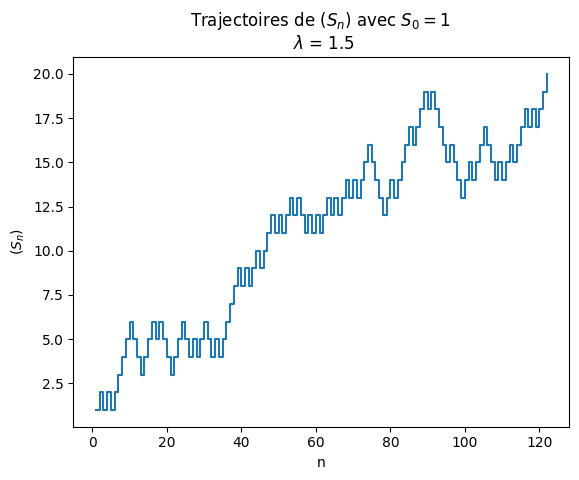

In [ ]:
Sn_plot_start_N(l=1.5,start=1,stop=20,nb=1)

##### Détermination de $p(\lambda)$

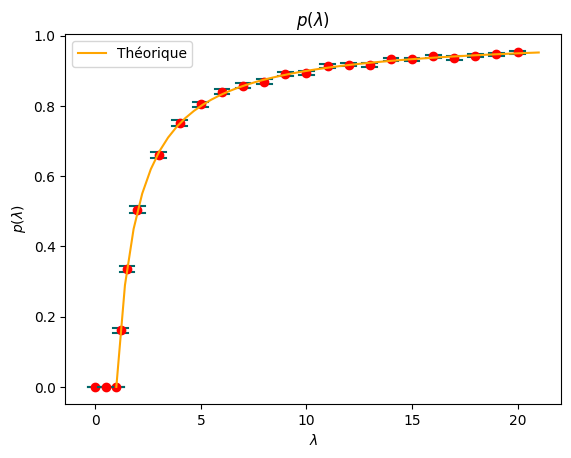

In [ ]:
p(L=list(range(0,21))+[0.5,1.2,1.5], k=100, N=int(1e4), horizontal_line_width=0.7)

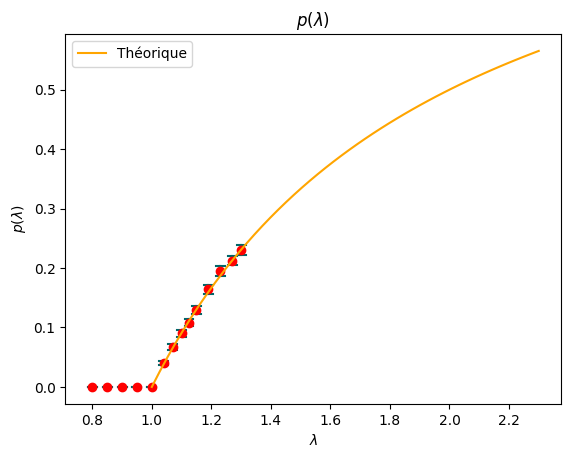

In [ ]:
p(L=[0.8,0.85,0.9,0.95,1,1.04,1.07,1.1,1.125,1.15,1.19,1.23,1.27,1.3], k=100, N=int(1e4), horizontal_line_width=0.03)

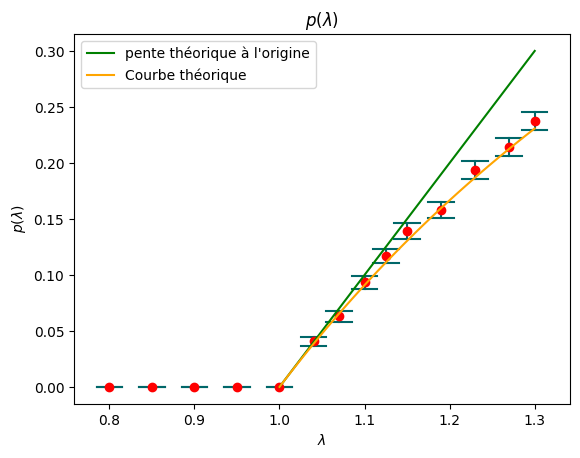

In [ ]:
p_deriv(L=[0.8,0.85,0.9,0.95,1,1.04,1.07,1.1,1.125,1.15,1.19,1.23,1.27,1.3], k=100, N=int(1e4), horizontal_line_width=0.03)

La fonction semble dérivable à droite.

### $A_n(\lambda)$

Vérification des résultats :   
Une analyse biblographique nous donne les résultats suivant :   

$ T = \inf \{n \in \mathbb{N} \mid S_n \in \{0, b\}\}  $ alos  $  A_b(\lambda) = P(S_T =  b) =  \frac{1 - \left( \frac{q}{p} \right)}{1 - \left( \frac{q}{p} \right)^{b}}$ avec $ p = 1-q = \frac{\lambda}{\lambda +1 } $

In [ ]:
def An_theorique(n,l) :
  p = l/(l+1)
  q= 1-p
  return (1-(q/p))/(1-(q/p)**n)

#### Méthode naïve

##### Fonctions

In [ ]:
def An_naif(l,n,nb=int(1e4)):
    """Calcule A_n(lambda) pour lambda, n fixés"""

    scale = 1/l
    S_max = np.zeros(nb)
    for i in range(nb):
        S = 1
        t_born = npr.exponential(scale)
        t_death = npr.exponential(1)
        t = min(t_born,t_death)
        while S != 0:
            if S == n:
                S_max[i] = 1
                break
            if t_born > t_death:
                S-=1
                t_death = t + npr.exponential(1)
            else:
                S+=1
                t_born = t + npr.exponential(scale)
            t = min(t_born,t_death)

    mean = np.mean(S_max)
    std = np.std(S_max)
    confidence_interval = 1.96 * std / np.sqrt(nb)

    return mean, max(mean - confidence_interval, 0), mean + confidence_interval

In [ ]:
def plot_An(parametres,function,nb):
    label = []

    for x in range(len(parametres)):
        (n,l) = parametres[x]
        label.append(f"{l},{n}")
        mean, bottom, top = function(l= l, n= n, nb= nb)

        left = x - 1 / 4
        right = x + 1 / 4
        color='#006769'

        plt.plot([x, x], [bottom, top], color=color)
        plt.plot([left, right], [top, top], color=color)
        plt.plot([left, right], [bottom, bottom], color=color)
        plt.plot(x, mean, 'o', color='red')
        if x == 0:
            plt.plot(x, An_theorique(n,l), 'o', color='orange',label="Théorique")
        else:
            plt.plot(x, An_theorique(n,l), 'o', color='orange')

    plt.xticks(ticks = range(len(parametres)),labels= label)
    plt.title(f"Estimation de $A_n(\lambda)$ \n Taille de la population : {nb}")
    plt.ylabel("$A_n(\lambda)$")
    plt.xlabel("$\lambda,n$")
    plt.grid()
    plt.legend()
    plt.show()

##### Tests

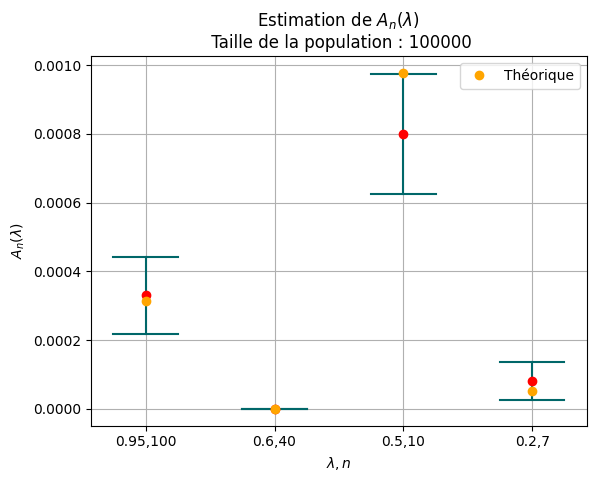

In [ ]:
parametres = [(100, 0.95), (40, 0.6), (10, 0.5), (7, 0.2)]

plot_An(parametres,An_naif,nb=int(1e5))

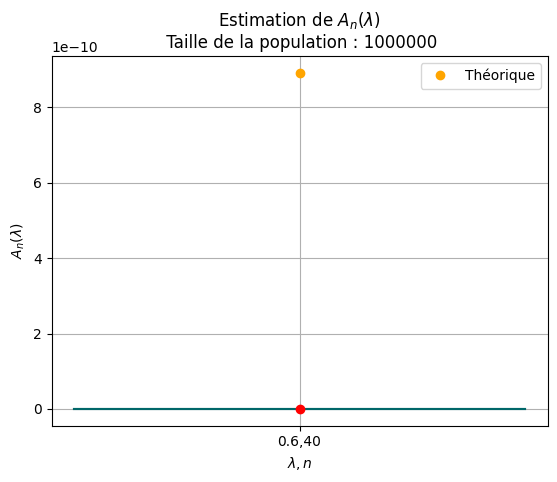

In [ ]:
plot_An([(40, 0.6)],An_naif,nb=int(1e6))

Les probabilités sont rares : la méthode naïve est insuffisante

#### Méthode de splitting

##### Fonctions

In [ ]:
def trajectoire(start,scale,stop):
    """Calcule une trajectoire (S_n) en repartant de start et s'arrêtant si elle atteint stop 0"""
    S_traj = [start]
    S = start
    t_born = npr.exponential(scale)
    t_death = npr.exponential(1)
    t = min(t_born, t_death)
    while S != 0 and S != stop:
        if t_born > t_death:
            S -= 1
            t_death = t + npr.exponential(1)
        else:
            S += 1
            t_born = t + npr.exponential(scale)
        S_traj.append(S)
        t = min(t_born, t_death)
    return S_traj

In [ ]:
def An_splitting(l,n,nb=100):
    scale = 1 / l
    traj = []
    maximums = np.zeros(nb)
    phat = 1

    #Trajectoires initiales
    for _ in range(nb):
        traj.append(trajectoire(start = 1,scale = scale, stop = n))
    for i in range(nb):
        maximums[i] = max(traj[i])

    L = np.min(maximums)
    K = np.argwhere(maximums == L).ravel()

    while L < n:
        phat *= (1 - K.size / nb)
        # Resampling procedure
        for i in K:
            Iprime = np.random.choice([i for i in range(nb) if i not in K])
            n0 = np.argmax(traj[Iprime] > L)  # First time X exceeds L
            traj[i] = np.concatenate((traj[Iprime][:n0], trajectoire(traj[Iprime][n0],scale,n)))
            maximums[i] = max(traj[i])
        L = np.min(maximums)
        K = np.argwhere(maximums == L).ravel()


    # Calculate confidence interval
    z_score = 1.96
    borneinf = max(0, phat - z_score * phat * np.sqrt(-np.log(phat)) / np.sqrt(nb))
    bornesup = phat + z_score * phat * np.sqrt(-np.log(phat)) / np.sqrt(nb)

    # Print results
    # print(f"L'estimation de la probabilité pour n={n}, l={l} est {phat:1.2e} ± {z_score * phat * np.sqrt(-np.log(phat)) / np.sqrt(nb)}")

    return phat, borneinf, bornesup

##### Tests

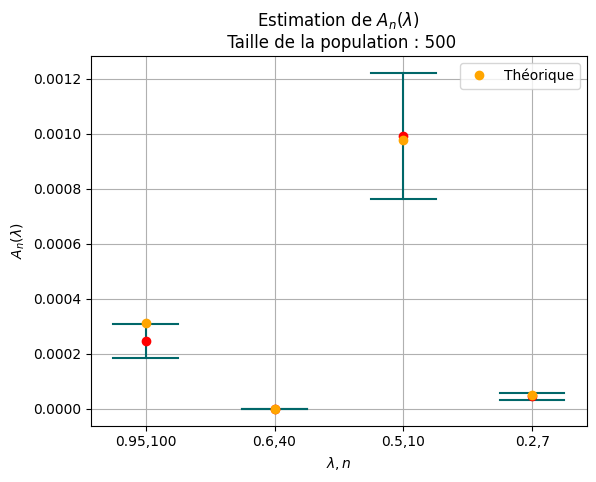

In [ ]:
parametres = [(100, 0.95), (40, 0.6), (10, 0.5), (7, 0.2)]

plot_An(parametres,An_splitting,nb=500)

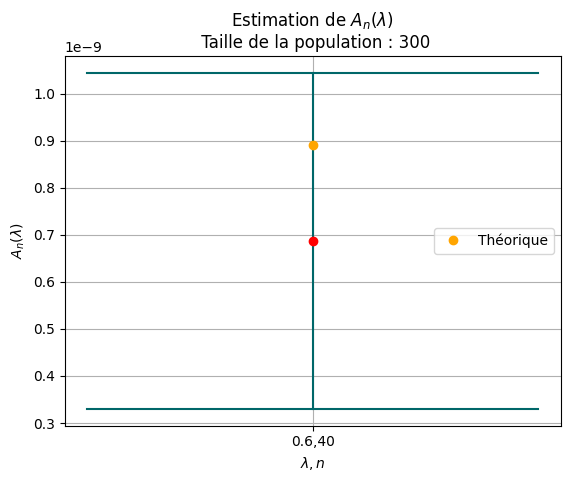

In [ ]:
plot_An([(40, 0.6)],An_splitting,nb=500)

La méthode de splitting est efficace pour les probabilités très faibles ! Elle reste par contre un peu plus couteuse pour des probabilités plus élevée.

### $Ã_n(\lambda)$

#### Méthode naïve

##### Fonctions

In [ ]:
def plot_Antilde(parametres,function,nb):
    label = []

    for x in range(len(parametres)):
        (n,l) = parametres[x]
        label.append(f"{l},{n}")
        mean, bottom, top = function(l= l, n= n, nb= nb)

        left = x - 1 / 4
        right = x + 1 / 4
        color='#006769'

        plt.plot([x, x], [bottom, top], color=color)
        plt.plot([left, right], [top, top], color=color)
        plt.plot([left, right], [bottom, bottom], color=color)
        plt.plot(x, mean, 'o', color='red')

    plt.xticks(ticks = range(len(parametres)),labels= label)
    plt.title(f"Estimation de $Ã_n(\lambda)$ \n Taille de la population : {nb}")
    plt.ylabel("$Ã_n(\lambda)$")
    plt.xlabel("$\lambda,n$")
    plt.grid()
    plt.show()

In [ ]:
def Antilde_naif(l,n,nb=int(1e4)):
    """Calcule Ã_n(lambda) pour lambda, n fixés"""

    scale = 1/l
    S_reach = np.zeros(nb)
    for i in range(nb):
        count = 1
        S = 1
        t_born = npr.exponential(scale)
        t_death = npr.exponential(1)
        t = min(t_born,t_death)
        while S != 0:
            if count == n:
                S_reach[i] = 1
                break
            if t_born > t_death:
                S-=1
                t_death = t + npr.exponential(1)
            else:
                S+=1
                count += 1
                t_born = t + npr.exponential(scale)
            t = min(t_born,t_death)

    mean = np.mean(S_reach)
    std = np.std(S_reach)
    confidence_interval = 1.96 * std / np.sqrt(nb)

    return mean, max(mean - confidence_interval, 0), mean + confidence_interval

##### tests

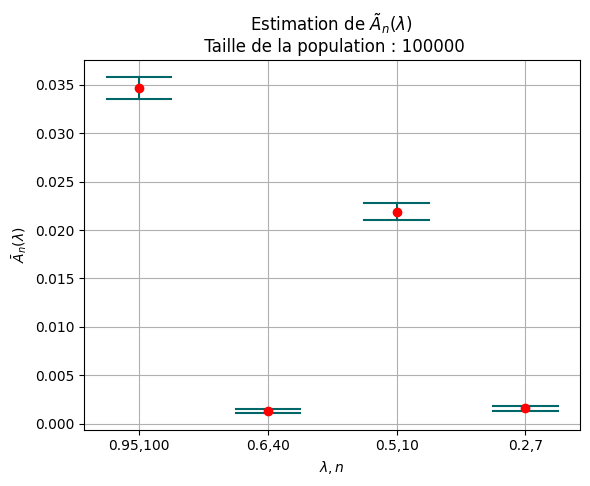

In [ ]:
parametres = [(100, 0.95), (40, 0.6), (10, 0.5), (7, 0.2)]

plot_Antilde(parametres,Antilde_naif,nb=int(1e5))

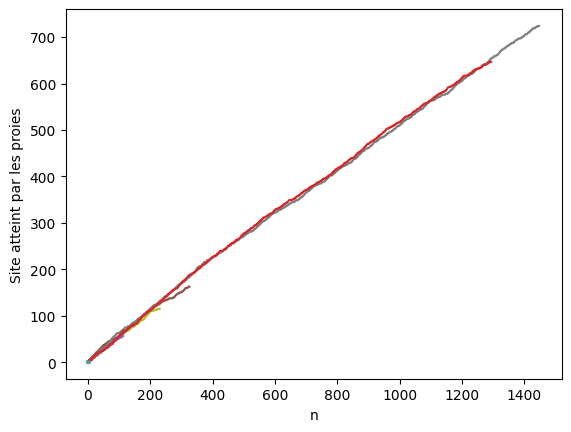

In [ ]:
#Mise en évidence que ce ne sont pas des evenements rares :
T = 1000

for _ in range (100) :
    x=[1]
    S = 1
    y=[1]
    tete = 1
    tetes=[]
    t_born = npr.exponential(1/0.95)
    t_death = npr.exponential(1)
    t = min(t_born,t_death)
    while S != 0 and t < T:
        if t_born > t_death:
            S-=1
            t_death = t + npr.exponential(1)
        else:
            S+=1
            tete+=1
            t_born = t + npr.exponential(1/0.95)
        y.append(tete)
        x.append(x[-1]+1)
        t = min(t_born,t_death)
    plt.plot(x,y)
plt.xlabel("n")
plt.ylabel("Site atteint par les proies")
plt.show()


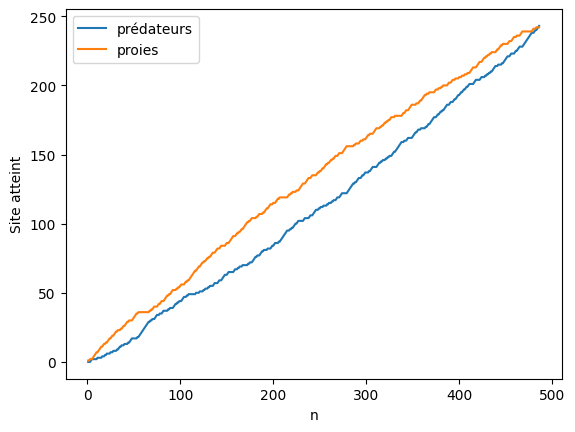

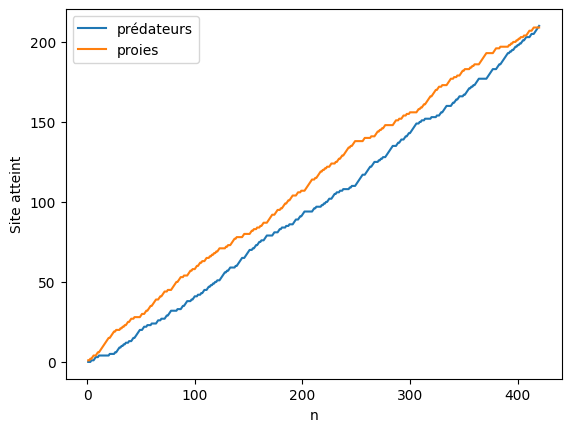

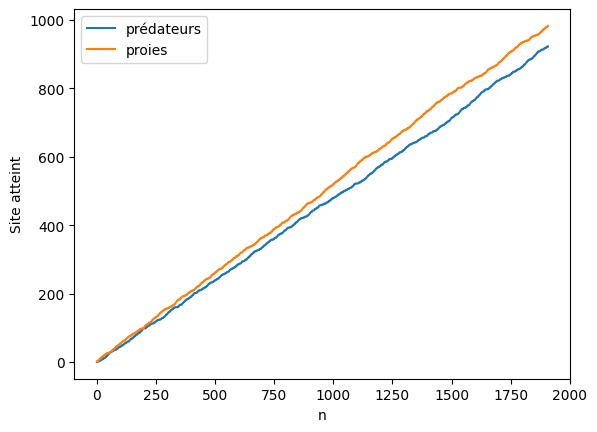

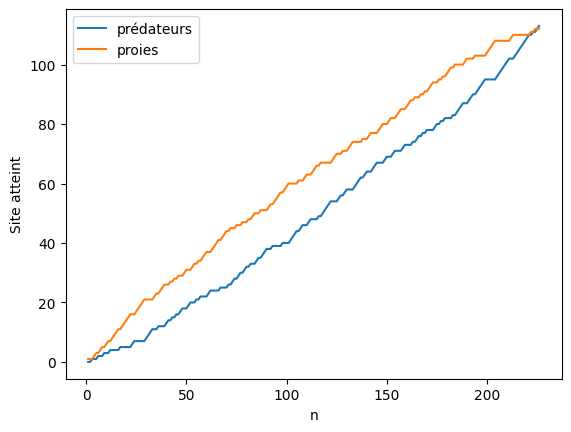

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]


In [ ]:
T = 1000

for k in range (100) :
    x=[1]
    S=1
    proie = 0
    prédateurs=[0]
    prédateur = 0
    proies=[1]
    t_born = npr.exponential(1/0.95)
    t_death = npr.exponential(1)
    t = min(t_born,t_death)
    while S != 0 and t < T:
        if t_born > t_death:
            S-=1
            prédateur+=1
            t_death = t + npr.exponential(1)
        else:
            S+=1
            proie+=1
            t_born = t + npr.exponential(1/0.95)
        proies.append(proie)
        prédateurs.append(prédateur)
        x.append(x[-1]+1)
        t = min(t_born,t_death)
    if (k>2 and proie>100 ) :
        plt.plot(x,prédateurs, label = "prédateurs")
        plt.plot(x,proies, label = "proies")
        plt.xlabel("n")
        plt.ylabel("Site atteint")
        plt.legend()
        plt.show()
print(x)



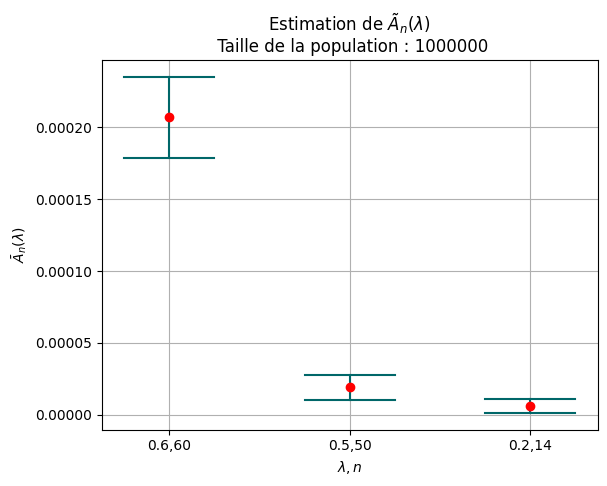

In [ ]:
parametres = [(60, 0.6), (50, 0.5), (14, 0.2)]

plot_Antilde(parametres,Antilde_naif,nb=int(1e6))

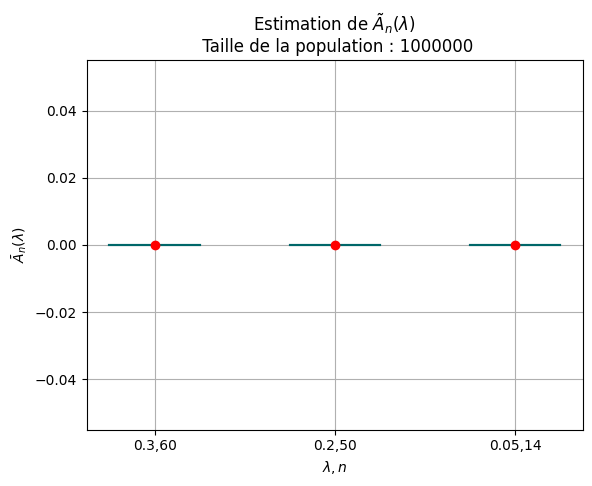

In [ ]:
parametres = [(60, 0.3), (50, 0.2), (14, 0.05)]

plot_Antilde(parametres,Antilde_naif,nb=int(1e6))

#### Splitting

##### Fonctions

In [ ]:
def trajectoire_bis(start,scale,stop,head):
    """Calcule une trajectoire en retenant le site maximal occupé (<= head)"""
    traj = [[start,head]]

    S = [start,head]
    t_born = npr.exponential(scale)
    t_death = npr.exponential(1)
    t = min(t_born, t_death)
    while S[0] != 0 and S[1] != stop:
        if t_born > t_death:
            S[0] -= 1
            t_death = t + npr.exponential(1)
        else:
            S[0] += 1
            S[1] +=1
            t_born = t + npr.exponential(scale)
        traj.append(S[:])

        t = min(t_born, t_death)
    return traj

In [ ]:
def Antilde_splitting(l,n,nb=100):
    scale = 1 / l
    traj = []
    tetes = np.zeros(nb)
    phat = 1

    for _ in range(nb):
        traj.append(trajectoire_bis(start = 1,scale = scale,stop = n, head = 1))
    for i in range(nb):
        tetes[i] = traj[i][-1][1]

    L = np.min(tetes)
    K = np.argwhere(tetes == L).ravel()

    while L < n:
        phat *= (1 - K.size / nb)
        # Resampling
        for i in K:
            Iprime = np.random.choice([i for i in range(nb) if i not in K])
            n0 = next(idx for idx, state in enumerate(traj[Iprime]) if state[1] > L)
            traj[i] = np.concatenate((traj[Iprime][:n0], trajectoire_bis(start= traj[Iprime][n0][0], scale= scale, stop= n, head= traj[Iprime][n0][1] )))
            tetes[i] = traj[i][-1][1]
        L = np.min(tetes)
        K = np.argwhere(tetes == L).ravel()

    # Intervalle de confiance
    borneinf = max(0, phat - 1.96 * phat * np.sqrt(-np.log(phat)) / np.sqrt(nb))
    bornesup = phat + 1.96 * phat * np.sqrt(-np.log(phat)) / np.sqrt(nb)

    return phat, borneinf, bornesup

##### Tests

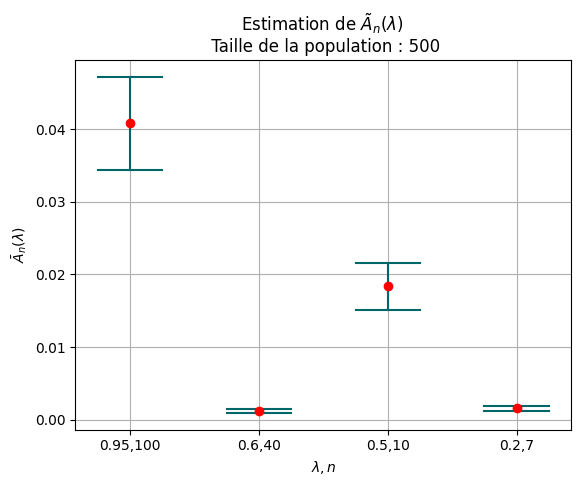

In [ ]:
parametres = [(100, 0.95), (40, 0.6), (10, 0.5), (7, 0.2)]

plot_Antilde(parametres,Antilde_splitting,nb=int(500))

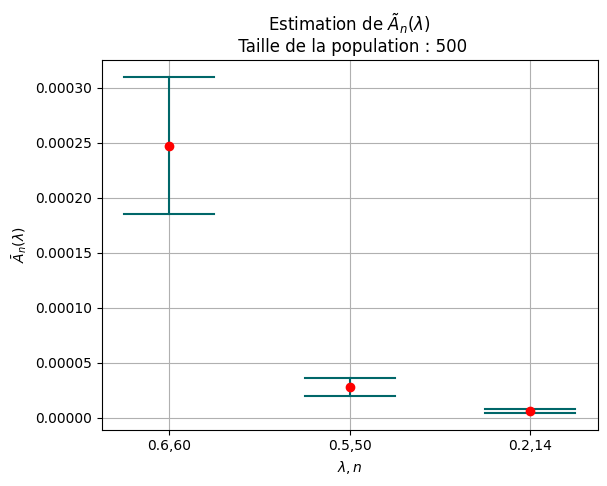

In [ ]:
parametres = [(60, 0.6), (50, 0.5), (14, 0.2)]

plot_Antilde(parametres,Antilde_splitting,nb=int(500))

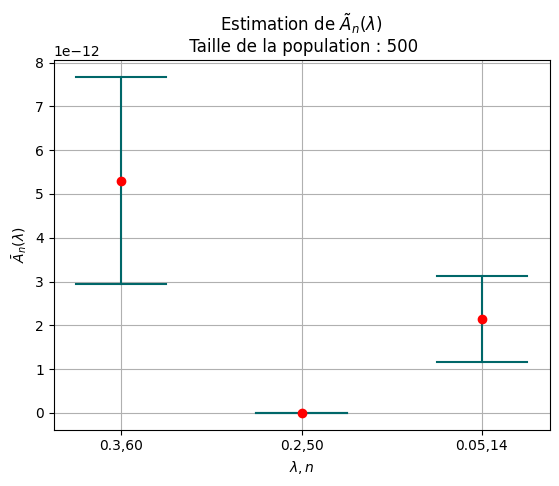

In [ ]:
parametres = [(60, 0.3), (50, 0.2), (14, 0.05)]

plot_Antilde(parametres,Antilde_splitting,nb=int(500))

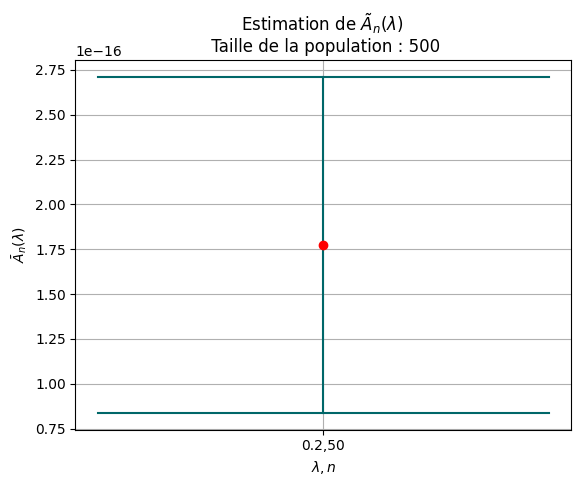

In [ ]:
plot_Antilde([(50, 0.2)],Antilde_splitting,nb=int(500))

### Equivalent de $A_n(\lambda)$

Pour découvrir l'équivalent, on passe au log et on étudie pour lambda fixé plusieurs valeurs de n

> Ajouter une citation



##### Fonctions

In [ ]:
def plot_equiv_An(l,N:np.ndarray,nb= 100, horizontal_line_width= 5):
    """Détermine a et b tq A_n(lambda) = a(lambda)*b(lambda)**n
    N = plage de données de n
    Trace la régression linéaire"""
    An = []
    color='#006769'

    for n in N:
        mean, bottom, top = An_splitting(l,n,nb)
        mean = np.log(mean)
        bottom = np.log(bottom)
        top = np.log(top)
        An.append(mean)

        # Affichage des points
        left = n - horizontal_line_width/2
        right = n + horizontal_line_width/2
        color='#006769'

        plt.plot([n, n], [bottom, top], color=color)
        plt.plot([left, right], [top, top], color=color)
        plt.plot([left, right], [bottom, bottom], color=color)
        plt.plot(n, mean, 'o', color='red')

    N = N.reshape(-1,1)
    An = np.array(An)
    An = An.reshape(-1,1)
    model = LinearRegression().fit(N, An)

    b = model.coef_[0]
    a = model.intercept_

    plt.plot(N,a + b*N, label = 'Régression linéaire')

    a = np.exp(a)
    b = np.exp(b)

    plt.title(f"$log(A_n) = log(a) + n \\times log(b)$ pour $\lambda = ${l} \n a = {round(a[0],2)}, b = {round(b[0],2)}")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def equiv_An(l,N:np.ndarray,nb= 100):
    """Détermine a et b tq A_n(lambda) = a(lambda)*b(lambda)**n
    N = plage de données de n"""
    An = []

    for n in N:
        mean = An_splitting(l,n,nb)[0]
        mean = np.log(mean)
        An.append(mean)


    N = N.reshape(-1,1)
    An = np.array(An)
    An = An.reshape(-1,1)
    model = LinearRegression().fit(N, An)

    b = model.coef_[0]
    a = model.intercept_

    a = np.exp(a)
    b = np.exp(b)

    return a[0], b[0]

In [ ]:
def tracer_a_b(L,N,nb):
    """Trace les fonctions a et b"""
    A = []
    B = []
    for l in L:
        a, b = equiv_An(l,N,nb)
        A.append(a)
        B.append(b)
    x = np.linspace(min(L), max(L),20)
    plt.plot(L,A,label="$a(\lambda)$, estimation")
    plt.plot(L,B,label="$b(\lambda)$, estimation")
    plt.plot(x,x, label="$b(\lambda)$, théorie")
    plt.plot(x,1/x-1, label="$a(\lambda)$, théorie")
    plt.title(f"Tracé de $a(\lambda)$ et $b(\lambda)$")
    plt.xlabel('$\lambda$')
    plt.legend()
    plt.grid()
    plt.show()

##### Tests

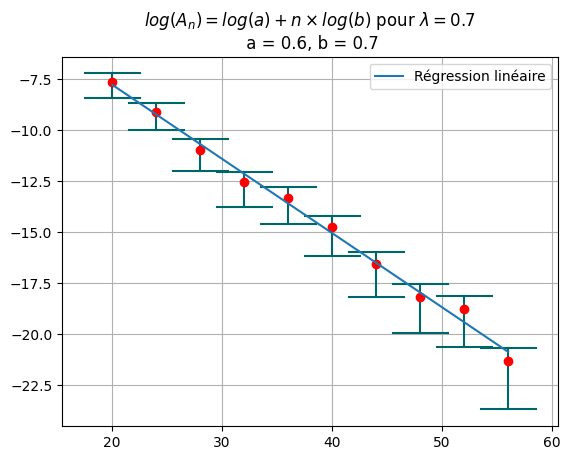

In [ ]:
plot_equiv_An(l = 0.7,N= np.arange(20,60,4),nb= 100, horizontal_line_width= 5)

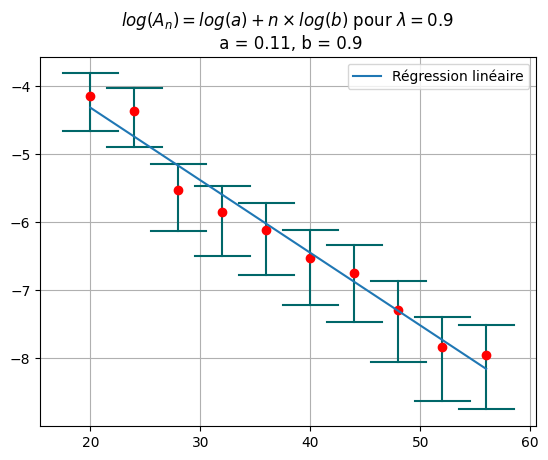

In [ ]:
plot_equiv_An(l = 0.9,N= np.arange(20,60,4),nb= 100, horizontal_line_width= 5)

<ipython-input-36-bc5b0356d8ba>:11: RuntimeWarning: divide by zero encountered in log
  bottom = np.log(bottom)


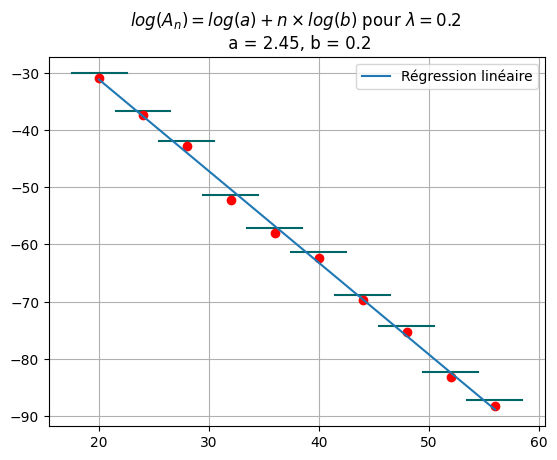

In [ ]:
plot_equiv_An(l = 0.2,N= np.arange(20,60,4),nb= 100, horizontal_line_width= 5)

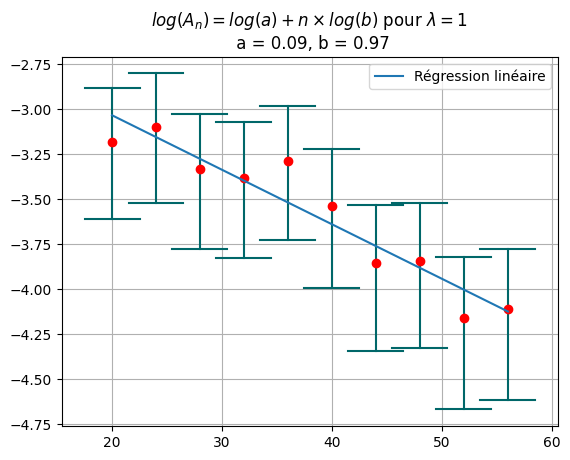

In [ ]:
plot_equiv_An(l = 1,N= np.arange(20,60,4),nb= 100, horizontal_line_width= 5)

Presque constant pour lambda = 1.

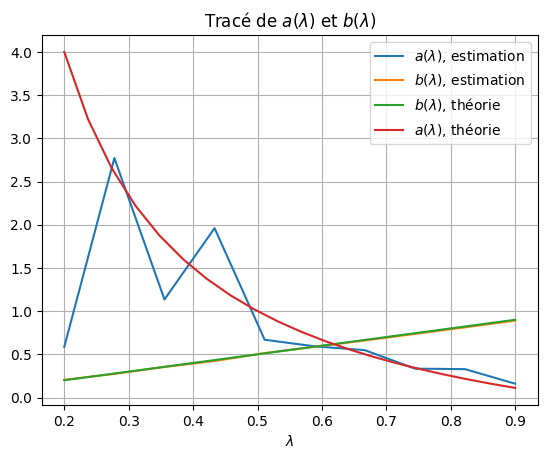

In [ ]:
tracer_a_b(L= np.linspace(0.2,0.9,10), N= np.linspace(20,60,10), nb= 100)

Pour affiner a, il faut augmenter nb. On remarque la dépendance de A_n en lambda puissance n.

## Partie 3

A mettre sur un fichier python, ne marche pas sur Jupyter

<ipython-input-2-2afcd70ff18b>:106: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, update, interval=50)
/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


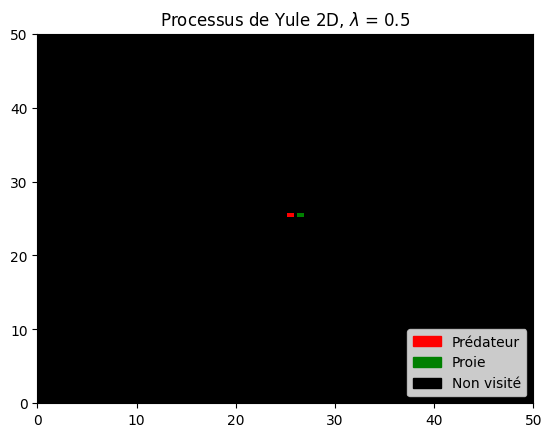

In [ ]:
# Utiliser ce code dans un nouveau fichier Python

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from queue import PriorityQueue
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Paramètres de la simulation
size = 50  # Taille de la grille
l = 0.5  # Taux de reproduction des proies
scale = 1/l
t = 0   # Suivi du temps d'évolution
t_queue = PriorityQueue() # Temps de naissance et de mort ordonnés

# État initial
grid = np.zeros((size, size))

grid[size//2, size//2] = -1  # Prédateur
grid[size//2, size//2 + 1] = 1   # Proie

# Temps de naissance et de mort des individus dans les cases non-visitées
t_queue.put((npr.exponential(1),(size//2, size//2 + 1)))
t_queue.put((npr.exponential(scale),(size//2+1, size//2 + 1)))
t_queue.put((npr.exponential(scale),(size//2-1, size//2 + 1)))
t_queue.put((npr.exponential(scale),(size//2, size//2 + 2)))

# Sauvegarde des cases vides qui vont faire naître des proies et des cases de proies qui vont être chassées
naissance = [(size//2+1, size//2 + 1),(size//2-1, size//2 + 1),(size//2, size//2 + 2)]
chasse = [(size//2, size//2 + 1)]


# Directions possibles pour se déplacer dans la grille
directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

def update(frame_number):
    global grid, t_queue, t, naissance, chasse

    # On récupère le prochain individu qui va naitre/mourir
    if t_queue.empty():
        return
    temps, pos = t_queue.get()
    i, j = pos

    t = temps

    # Si la case était vide, on y fait naître une proie et on prépare les naissances pour les cases nouvelles découvertes aux alentours
    if grid[i,j] == 0:
        peut_naitre = False     #Vérifie qu'il y ait bien toujours un individu à côté pour donner naissance
        for d in directions:
            ni, nj = i + d[0], j + d[1]
            if 0 <= ni < size and 0 <= nj < size and grid[ni, nj] == 1:
                peut_naitre = True

        if peut_naitre :
            grid[i,j] = 1

            for d in directions:
                ni, nj = i + d[0], j + d[1]
                if 0 <= ni < size and 0 <= nj < size and grid[ni, nj] == 0 and (ni, nj) not in naissance: #Si la case est vide et non préparée
                    t_queue.put((t + npr.exponential(scale),(ni, nj)))
                    naissance.append((ni, nj))
                if 0 <= ni < size and 0 <= nj < size and grid[ni, nj] == -1 : #Si la case est à côté d'un prédateur, on commence la chasse
                    t_queue.put((t + npr.exponential(1),(i, j)))
                    chasse.append((i, j))

    # Sinon, la proie va être chassée
    elif grid[i,j] == 1:
        grid[i,j] = -1

        for d in directions:
            ni, nj = i + d[0], j + d[1]
            if 0 <= ni < size and 0 <= nj < size and grid[ni, nj] == 1 and (ni, nj) not in chasse: #Si la case est une proie non en chasse
                t_queue.put((t + npr.exponential(scale),(ni, nj)))
                chasse.append((ni, nj))

    mat.set_array(grid.ravel())
    text.set_text(f't = {round(t,2)}')
    return [mat,text]

fig, ax = plt.subplots()
cmap = ListedColormap(['red', 'black', 'green'])
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = plt.Normalize(-1, 1)
mat = ax.pcolormesh(grid, edgecolors='k', linewidth=1, cmap=cmap, vmin=-1, vmax=1)
text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=14, verticalalignment='top',c='white')

# Légende
predateur_patch = mpatches.Patch(color='red', label='Prédateur')
proie_patch = mpatches.Patch(color='green', label='Proie')
vide_patch = mpatches.Patch(color='black', label='Non visité')
plt.legend(handles=[predateur_patch, proie_patch, vide_patch], loc='lower right')

# Pour mettre sur pause avec la barre espace
paused = False

def pause(event):
    global paused
    if event.key == ' ':
        if paused:
            ani.event_source.start()
        else:
            ani.event_source.stop()
        paused = not paused

fig.canvas.mpl_connect('key_press_event', pause)

ani = animation.FuncAnimation(fig, update, interval=50)

plt.title(f"Processus de Yule 2D, $\lambda$ = {l}")
plt.show()


In [ ]:
def process_2D_end (l,T,size):
    """Affiche le graphique de l'évolution 2D au bout du temps T"""
    # Paramètres de la simulation
    size = 50  # Taille de la grille
    l = 0.5  # Taux de reproduction des proies
    scale = 1/l
    t = 0   # Suivi du temps d'évolution
    T = 20 # Fin
    t_queue = PriorityQueue() # Temps de naissance et de mort ordonnés
    S = 1

    # État initial
    grid = np.zeros((size, size))

    grid[size//2, size//2] = -1  # Prédateur
    grid[size//2, size//2 + 1] = 1   # Proie

    # Temps de naissance et de mort des individus dans les cases non-visitées
    t_queue.put((npr.exponential(1),(size//2, size//2 + 1)))
    t_queue.put((npr.exponential(scale),(size//2+1, size//2 + 1)))
    t_queue.put((npr.exponential(scale),(size//2-1, size//2 + 1)))
    t_queue.put((npr.exponential(scale),(size//2, size//2 + 2)))

    # Sauvegarde des cases vides qui vont faire naître des proies et des cases de proies qui vont être chassées
    naissance = [(size//2+1, size//2 + 1),(size//2-1, size//2 + 1),(size//2, size//2 + 2)]
    chasse = [(size//2, size//2 + 1)]


    # Directions possibles pour se déplacer dans la grille
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while t < T:

        # On récupère le prochain individu qui va naitre/mourir
        if t_queue.empty():
            break

        temps, pos = t_queue.get()
        i, j = pos

        t = temps

        # Si la case était vide, on y fait naître une proie et on prépare les naissances pour les cases nouvelles découvertes aux alentours
        if grid[i,j] == 0:
            peut_naitre = False     #Vérifie qu'il y ait bien toujours un individu à côté pour donner naissance
            for d in directions:
                ni, nj = i + d[0], j + d[1]
                if 0 <= ni < size and 0 <= nj < size and grid[ni, nj] == 1:
                    peut_naitre = True


            if peut_naitre :
                grid[i,j] = 1
                S += 1

                for d in directions:
                    ni, nj = i + d[0], j + d[1]
                    if 0 <= ni < size and 0 <= nj < size and grid[ni, nj] == 0 and (ni, nj) not in naissance: #Si la case est vide et non préparée
                        t_queue.put((t + npr.exponential(scale),(ni, nj)))
                        naissance.append((ni, nj))
                    if 0 <= ni < size and 0 <= nj < size and grid[ni, nj] == -1 : #Si la case est à côté d'un prédateur, on commence la chasse
                        t_queue.put((t + npr.exponential(1),(i, j)))
                        chasse.append((i, j))

        # Sinon, la proie va être chassée
        elif grid[i,j] == 1:
            grid[i,j] = -1
            S -= 1

            for d in directions:
                ni, nj = i + d[0], j + d[1]
                if 0 <= ni < size and 0 <= nj < size and grid[ni, nj] == 1 and (ni, nj) not in chasse: #Si la case est une proie non en chasse
                    t_queue.put((t + npr.exponential(scale),(ni, nj)))
                    chasse.append((ni, nj))

    fig, ax = plt.subplots()
    cmap = ListedColormap(['red', 'black', 'green'])
    ax.pcolormesh(grid, edgecolors='k', linewidth=1, cmap=cmap, vmin=-1, vmax=1)

    # Légende
    predateur_patch = mpatches.Patch(color='red', label='Prédateur')
    proie_patch = mpatches.Patch(color='green', label='Proie')
    vide_patch = mpatches.Patch(color='black', label='Non visité')
    plt.legend(handles=[predateur_patch, proie_patch, vide_patch], loc='lower right')
    plt.title(f"Processus 2D pour $\lambda$ = {l} : $S_n$ = {S}")

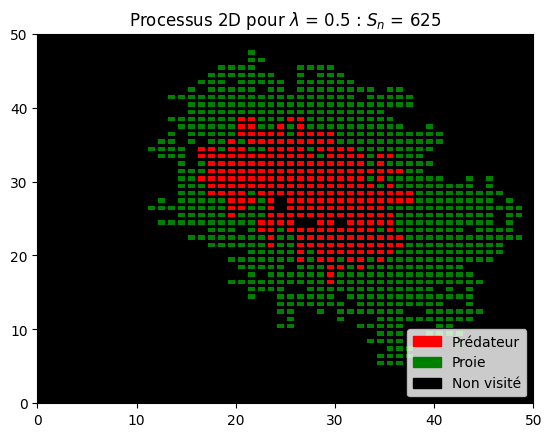

In [ ]:
process_2D_end(0.5,20,50)

In [ ]:
def process_2D (l,T,size):
    """Retourne la population de proie au bout du temps T"""
    # Paramètres de la simulation
    size = 50  # Taille de la grille
    l = 0.5  # Taux de reproduction des proies
    scale = 1/l
    t = 0   # Suivi du temps d'évolution
    T = 20 # Fin
    t_queue = PriorityQueue() # Temps de naissance et de mort ordonnés
    S = 1

    # État initial
    grid = np.zeros((size, size))

    grid[size//2, size//2] = -1  # Prédateur
    grid[size//2, size//2 + 1] = 1   # Proie

    # Temps de naissance et de mort des individus dans les cases non-visitées
    t_queue.put((npr.exponential(1),(size//2, size//2 + 1)))
    t_queue.put((npr.exponential(scale),(size//2+1, size//2 + 1)))
    t_queue.put((npr.exponential(scale),(size//2-1, size//2 + 1)))
    t_queue.put((npr.exponential(scale),(size//2, size//2 + 2)))

    # Sauvegarde des cases vides qui vont faire naître des proies et des cases de proies qui vont être chassées
    naissance = [(size//2+1, size//2 + 1),(size//2-1, size//2 + 1),(size//2, size//2 + 2)]
    chasse = [(size//2, size//2 + 1)]


    # Directions possibles pour se déplacer dans la grille
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while t < T:

        # On récupère le prochain individu qui va naitre/mourir
        if t_queue.empty():
            break

        temps, pos = t_queue.get()
        i, j = pos

        t = temps

        # Si la case était vide, on y fait naître une proie et on prépare les naissances pour les cases nouvelles découvertes aux alentours
        if grid[i,j] == 0:
            peut_naitre = False     #Vérifie qu'il y ait bien toujours un individu à côté pour donner naissance
            for d in directions:
                ni, nj = i + d[0], j + d[1]
                if 0 <= ni < size and 0 <= nj < size and grid[ni, nj] == 1:
                    peut_naitre = True


            if peut_naitre :
                grid[i,j] = 1
                S += 1

                for d in directions:
                    ni, nj = i + d[0], j + d[1]
                    if 0 <= ni < size and 0 <= nj < size and grid[ni, nj] == 0 and (ni, nj) not in naissance: #Si la case est vide et non préparée
                        t_queue.put((t + npr.exponential(scale),(ni, nj)))
                        naissance.append((ni, nj))
                    if 0 <= ni < size and 0 <= nj < size and grid[ni, nj] == -1 : #Si la case est à côté d'un prédateur, on commence la chasse
                        t_queue.put((t + npr.exponential(1),(i, j)))
                        chasse.append((i, j))

        # Sinon, la proie va être chassée
        elif grid[i,j] == 1:
            grid[i,j] = -1
            S -= 1

            for d in directions:
                ni, nj = i + d[0], j + d[1]
                if 0 <= ni < size and 0 <= nj < size and grid[ni, nj] == 1 and (ni, nj) not in chasse: #Si la case est une proie non en chasse
                    t_queue.put((t + npr.exponential(scale),(ni, nj)))
                    chasse.append((ni, nj))

    return S

In [ ]:
process_2D(0.5,20,50)

266

In [ ]:
def histo_2D(l,T = 20,size = 50, nb=1000):
    Y = np.array([process_2D(l,T,size) for _ in range(nb)])
    plt.hist(Y,bins='auto')
    plt.plot(0,np.sum(Y==0), 'o', color= 'red', label = "Nombre de $S_n$ qui sont égaux à 0" )
    plt.title(f"Répartition des $S_n$ pour {nb} processus \n $\lambda$ = {l}, temps d'arrêt : {T}s")
    plt.xlabel("$S_n$")
    plt.legend()
    plt.show()


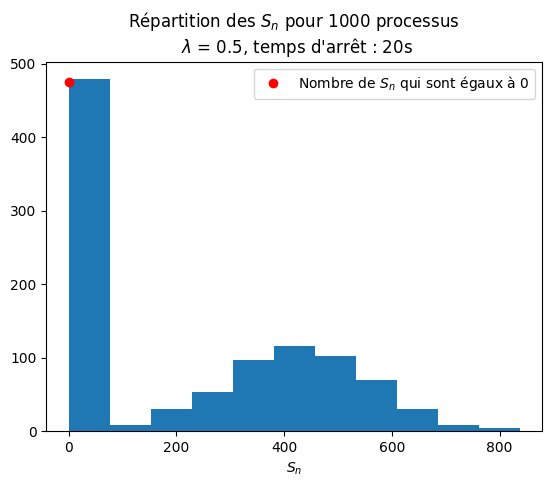

In [ ]:
histo_2D(0.5,20,50)

In [ ]:
def p_2D(L,T = 20,size = 50, nb=1000, horizontal_line_width=0.1):
    for l in L:
        Y = np.array([process_2D(l,T,size) for _ in range(nb)])
        plot_confidence_interval(l,Y >= 100, horizontal_line_width=horizontal_line_width)
    plt.title(f"Estimation $p(\lambda)$ pour {nb} processus")
    plt.xlabel("$\lambda$")
    plt.ylabel("$p(\lambda)$")
    plt.show()

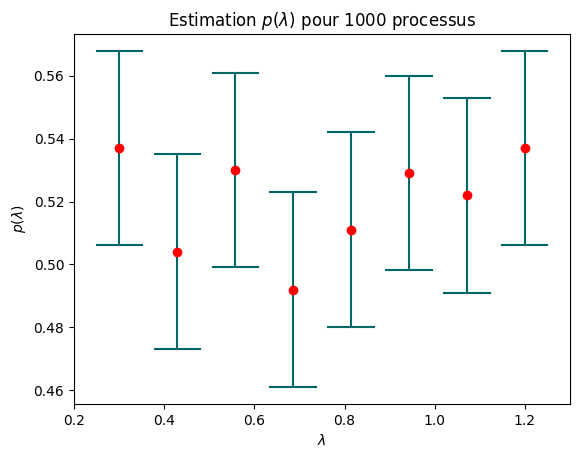

In [ ]:
p_2D(L = np.linspace(0.3,1.2,8))

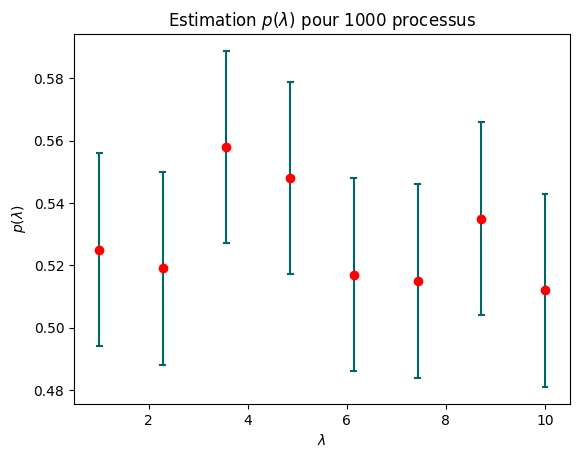

In [ ]:
p_2D(L = np.linspace(1,10,8))